## Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from qutip.qip.operations import *
from qutip.qip.circuit import *
import sys
sys.path.append('../SimulationCode/')
from BlindGatesSimulation import *
from fiber_network import FiberNetwork
from SiVnodes import SiV
from SiVgates import *
from Plots import *
import pandas as pd
import glob


In [ ]:
# colors for plots
c1 = '#F15F57'
c2 = '#F6851F'
c3 = '#FDB913'
c4 = '#743062'
c5 = '#C87EB5'
c6 = '#4CC0B3'
c7 = '#1C9AAA'

## Define SiVs 

In [ ]:
# Create SiVs:

#Server A, G12
siv_a = SiV(kappa_in= (74.9 - 54.5)*(10**3), kappa_w= (54.5)*(10**3), g=5.6*(10**3), wCav = (0)*(10**3), 
             wSiv = -(479.8 -639.6)*(10**3), dwEl = 0.5*(10**3)) # G12
#Server B, B16
siv_b = SiV(kappa_in= (43.5 - 26.0)*(10**3), kappa_w= (26.0)*(10**3), g=8.5*(10**3), wCav = (0)*(10**3), 
             wSiv = -(804.9 -657.6)*(10**3), dwEl = -0.5*(10**3)) # B16

### Move the SiV to the desired contrast point

In [ ]:
siv_b.set_contrast(50)
siv_a.set_contrast(15)

## Setup single Node experiments in B16

In [ ]:
# Create Networks:
b16_network = FiberNetwork(siv_b) # this device is now in B16 fridge

# Create Simulation:
sim = BlindComputing(b16_network)

In [ ]:
# Double check the contrast
contrast = siv_a.get_best_contrast()
print("Node A contrast = ", contrast)
contrast = siv_b.get_best_contrast()
print("Node B contrast = ", contrast)


### SiV related plots

In [ ]:
## Plot 
# generate plots of reflectivity

wl_A = siv_a.get_plotaxis()
wl_B = siv_b.get_plotaxis()

wl_read_optimum_A = siv_a.freq_optimum()
wl_read_optimum_B = siv_b.freq_optimum()

figure, ax = plt.subplots(2, 2, figsize=(15, 6))

ax[0,0].plot(wl_A, np.abs(siv_a.cav_refl(wl_A)['refl_refl'])**2, color = 'green')
ax[0,0].plot(wl_A, np.abs(siv_a.cav_refl(wl_A)['nonrefl_refl'])**2,color = 'lightgreen')
ax[0,0].set_xlabel('freq, MHz')
ax[0,0].set_ylabel('Intensity reflection')
ax[0,0].axvline(x = wl_read_optimum_A, color = 'black', label = 'G12')
ax[0,0].legend()

ax[0,1].plot(wl_B, np.abs(siv_b.cav_refl(wl_B)['refl_refl'])**2, color = 'red')
ax[0,1].plot(wl_B, np.abs(siv_b.cav_refl(wl_B)['nonrefl_refl'])**2, color = 'pink')
ax[0,1].set_xlabel('freq, MHz')
ax[0,1].set_ylabel('Intensity reflection')
ax[0,1].axvline(x = wl_read_optimum_B, color = 'black', label = 'B16')
ax[0,1].legend()

ax[1,0].plot(wl_A, np.angle(siv_a.cav_refl(wl_A)['refl_refl']), color = 'green')
ax[1,0].plot(wl_A, np.angle(siv_a.cav_refl(wl_A)['nonrefl_refl']),color = 'lightgreen')
ax[1,0].set_xlabel('freq, MHz')
ax[1,0].set_ylabel('Phase reflection')
ax[1,0].axvline(x = wl_read_optimum_A, color = 'black', label = 'G12')
ax[1,0].legend()

ax[1,1].plot(wl_B, np.angle(siv_b.cav_refl(wl_B)['refl_refl']), color = 'red')
ax[1,1].plot(wl_B, np.angle(siv_b.cav_refl(wl_B)['nonrefl_refl']), color = 'pink')
ax[1,1].set_xlabel('freq, MHz')
ax[1,1].set_ylabel('Phase reflection')
ax[1,1].axvline(x = wl_read_optimum_B, color = 'black', label = 'B16')
ax[1,1].legend()

plt.show()

## Single blind gates with electron as a function of phi

In [ ]:
## Perfect single qubit gate with X+ init and multiple phi for Fig1 B

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real' #'real'
               }

el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())

mu = 0.05
# sim.single_node_electron_photon_entanglement(el_initial, imperfections, mu)

cluster_state_length = 1
phi1 = [0, np.pi/8, 2*np.pi/8, 3*np.pi/8, 4*np.pi/8, 5*np.pi/8, 6*np.pi/8, 7*np.pi/8, 8*np.pi/8]
phi2 = 0
phi3 = 0

n_rounds = 2
n_col = 6

xp_array_angle_cl = np.empty((0, 2), dtype=float)
xp_array_angle_s = np.empty((0, 2), dtype=float)

for j in range(len(phi1)):

    xp_array = np.empty((0, n_col), dtype=float)
    rho_init_xp_array = np.empty((2, 2), dtype=float)

    phi1e = phi1[j]
    print("Phi angle = ", phi1e)
    for i in range(n_rounds): 
        rho_init_xp, Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
        rho_init_xp_array = np.append(rho_init_xp_array, rho_init_xp[0], axis = 0)
        xp_array = np.append(xp_array, [[Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s]], axis = 0)
    # Average the data and save as a dict
    i = 0
    output_xp_mean_cl = np.mean(xp_array[:, i])
    output_xp_std_cl = np.std(xp_array[:, i], ddof=1)
    i = 3
    output_xp_mean_s = np.mean(xp_array[:, i])
    output_xp_std_s = np.std(xp_array[:, i], ddof=1)
    
    xp_array_angle_cl = np.append(xp_array_angle_cl, [[output_xp_mean_cl, output_xp_std_cl]], axis = 0)
    xp_array_angle_s = np.append(xp_array_angle_s, [[output_xp_mean_s, output_xp_std_s]], axis = 0)


In [ ]:
# Create the plot
plt.errorbar(phi1,  xp_array_angle_s[: , 0], yerr= xp_array_angle_s[: , 1]/np.sqrt(n_rounds), fmt='o', ecolor='r', capsize=2, capthick=2, linestyle='None')
plt.errorbar(phi1,  xp_array_angle_cl[: , 0], yerr= xp_array_angle_cl[: , 1]/np.sqrt(n_rounds), fmt='o', ecolor='r', capsize=2, capthick=2, linestyle='None')

plt.xlabel('phi (rad)')
plt.ylabel('X+')
plt.yscale('linear')
plt.xscale('linear')
plt.title('Single qubit roatation') 

plt.show()

### Save data in a file

In [ ]:

data = {
    'phi': phi1,
    'xp_s': xp_array_angle_s[: , 0],
    'xp_s_err': xp_array_angle_s[: , 1]/np.sqrt(n_rounds),
    'xp_cl': xp_array_angle_cl[: , 0],
    'xp_cl_err': xp_array_angle_cl[: , 1]/np.sqrt(n_rounds),

}


df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleGates_xpinit_xpfinal_phis_contrast100_{n_rounds}pts_mu{mu}_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)

### Read the data from a file and plot

In [ ]:
# Read the CSV file into a DataFrame
file_path = '/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/*.csv'
csv_file = glob.glob(file_path)
df = pd.read_csv(csv_file[0])

# Extract the columns you want to plot
phi = df['phi']
xp_s = df['xp_s']
xp_s_err= df['xp_s_err']
xp_cl = df['xp_cl']
xp_cl_err = df['xp_cl_err']


# Read the CSV file into a DataFrame
file_path = '/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/*.csv'
csv_file = glob.glob(file_path)
df = pd.read_csv(csv_file[1])

# Extract the columns you want to plot
phi_mu005 = df['phi']
xp_s_mu005 = df['xp_s']
xp_s_err_mu005 = df['xp_s_err']
xp_cl_mu005 = df['xp_cl']
xp_cl_err_mu005 = df['xp_cl_err']

# Read the CSV file into a DataFrame
file_path = '/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/*.csv'
csv_file = glob.glob(file_path)
df = pd.read_csv(csv_file[4])

# Extract the columns you want to plot
phi_contr4 = df['phi']
xp_s_contr4 = df['xp_s']
xp_s_err_contr4 = df['xp_s_err']
xp_cl_contr4 = df['xp_cl']
xp_cl_err_contr4 = df['xp_cl_err']


# Read the CSV file into a DataFrame
file_path = '/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/*.csv'
csv_file = glob.glob(file_path)
df = pd.read_csv(csv_file[2])

# Extract the columns you want to plot
phi_contr16 = df['phi']
xp_s_contr16 = df['xp_s']
xp_s_err_contr16 = df['xp_s_err']
xp_cl_contr16 = df['xp_cl']
xp_cl_err_contr16 = df['xp_cl_err']

file_path = '/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/*.csv'
csv_file = glob.glob(file_path)
df = pd.read_csv(csv_file[3])

# Extract the columns you want to plot
phi_contr100 = df['phi']
xp_s_contr100 = df['xp_s']
xp_s_err_contr100 = df['xp_s_err']
xp_cl_contr100 = df['xp_cl']
xp_cl_err_contr100 = df['xp_cl_err']




In [ ]:
# Plot the data with error bars

plt.figure(figsize=(10, 6))
plt.errorbar(phi, xp_s, yerr=xp_s_err,  fmt='o',
             color=c1,           # Marker edge color
             markerfacecolor=c1, # Marker fill color
             markeredgewidth=2,       # Thickness of marker edge
             ecolor=c1,          # Error bar color
             capsize=2, 
             markersize=7,          # Size of the markers (increase this value to make points bigger)
             alpha=0.8,                   # Transparency for edge and error bars
             label='perfect')
plt.plot(phi, xp_s, color=c1)
plt.errorbar(phi, xp_cl, yerr=xp_cl_err,color=c1, fmt='o', capsize=5)
plt.plot(phi, xp_cl, color=c1)


plt.errorbar(phi_mu005, xp_s_mu005, yerr=xp_s_err_mu005,  fmt='o',
             color=c2,           # Marker edge color
             markerfacecolor=c2, # Marker fill color
             markeredgewidth=2,       # Thickness of marker edge
             ecolor=c2,          # Error bar color
             capsize=2, 
             markersize=7,          # Size of the markers (increase this value to make points bigger)
             alpha=0.8,                   # Transparency for edge and error bars
             label='mu=0.05')
plt.plot(phi_mu005, xp_s_mu005, color=c2)
plt.errorbar(phi_mu005, xp_cl_mu005, yerr=xp_cl_err_mu005,color=c2, fmt='o', capsize=5)
plt.plot(phi_mu005, xp_cl_mu005, color=c2)

# Plot the data with error bars
plt.errorbar(phi_contr4, xp_s_contr4, yerr=xp_s_err_contr4,  fmt='o',
             color=c3,           # Marker edge color
             markerfacecolor=c3, # Marker fill color
             markeredgewidth=2,       # Thickness of marker edge
             ecolor=c3,          # Error bar color
             capsize=2, 
             markersize=7,          # Size of the markers (increase this value to make points bigger)
             alpha=0.8,                   # Transparency for edge and error bars
             label='contr=4.5')
plt.plot(phi_contr4, xp_s_contr4, color=c3)

plt.errorbar(phi_contr4, xp_cl_contr4, yerr=xp_cl_err_contr4,color=c3, fmt='o', capsize=5)
plt.plot(phi_contr4, xp_cl_contr4, color=c3)

# Plot the data with error bars
plt.errorbar(phi_contr16, xp_s_contr16, yerr=xp_s_err_contr16,  fmt='o',
             color=c4,           # Marker edge color
             markerfacecolor=c4, # Marker fill color
             markeredgewidth=2,       # Thickness of marker edge
             ecolor=c4,          # Error bar color
             capsize=2, 
             markersize=7,          # Size of the markers (increase this value to make points bigger)
             alpha=0.8,                   # Transparency for edge and error bars
             label='contr=16')
plt.plot(phi_contr16, xp_s_contr16, color=c4)

plt.errorbar(phi_contr16, xp_cl_contr16, yerr=xp_cl_err_contr16,color=c4, fmt='o', capsize=5)
plt.plot(phi_contr16, xp_cl_contr16, color=c4)

# Plot the data with error bars
plt.errorbar(phi_contr100, xp_s_contr100, yerr=xp_s_err_contr100,  fmt='o',
             color=c5,           # Marker edge color
             markerfacecolor=c5, # Marker fill color
             markeredgewidth=2,       # Thickness of marker edge
             ecolor=c5,          # Error bar color
             capsize=2, 
             markersize=7,          # Size of the markers (increase this value to make points bigger)
             alpha=0.8,                   # Transparency for edge and error bars
             label='contr=100')
plt.plot(phi_contr100, xp_s_contr100, color=c5)


plt.errorbar(phi_contr100, xp_cl_contr100, yerr=xp_cl_err_contr100,color=c5, fmt='o', capsize=5)
plt.plot(phi_contr100, xp_cl_contr100, color=c5)

# Add labels and title
plt.xlabel('Phi')
plt.ylabel('xp_s')
plt.title('xp_s vs Phi with Error Bars')
plt.legend()

# Show the plot
plt.show()

## Single gate fidelities and blindness as a function of mu errors

In [ ]:
mu_list = np.linspace(0.001, 1, 5)
phi1 = [0, np.pi/4, np.pi/2, 3*np.pi/4]
phi2 = 0
phi3 = 0
el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())

siv_b.set_contrast(50)
actual_contrast = siv_b.get_best_contrast()
print(actual_contrast)

In [ ]:
## Perfect single qubit gate with X+ init and multiple phi for Fig1 B

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real' #'real'
               }


# sim.single_node_electron_photon_entanglement(el_initial, imperfections, mu)

cluster_state_length = 1

n_rounds = 1000
n_col = 6

xp_array_angle_cl = np.empty((0, 2), dtype=float)
xp_array_angle_s = np.empty((0, 2), dtype=float)

rho_ave_cl_phi_mu = np.empty((0, 2, 2), dtype=complex)
rho_std_cl_phi_mu = np.empty((0, 2, 2), dtype=complex)

rho_ave_s_phi_mu = np.empty((0, 2, 2), dtype=complex)
rho_std_s_phi_mu = np.empty((0, 2, 2), dtype=complex)

rates_apd1_apd2_angle = np.empty((0, 2), dtype=float)


#phi list
for j in range(len(phi1)):
    phi1e = phi1[j]
    # my list
    rho_ave_cl_mu = np.empty((0, 2, 2), dtype=complex)
    rho_std_cl_mu = np.empty((0, 2, 2), dtype=complex)

    rho_ave_s_mu = np.empty((0, 2, 2), dtype=complex)
    rho_std_s_mu = np.empty((0, 2, 2), dtype=complex)

    rates_apd1_apd2 = np.empty((0, 2), dtype=float)


    for i in range(len(contrast_list)):
        mu = mu_list[i]
        xp_array = np.empty((0, n_col), dtype=float)
        rho_init_xp_array = np.empty((0, 2, 2), dtype=complex)
        rho_click = np.empty((0, 1), dtype=int)

        print("Phi angle = ", phi1e)
        for i in range(n_rounds): 
            rho_init_xp, Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
            rho_init_xp_array = np.append(rho_init_xp_array, [rho_init_xp[0]], axis = 0)
            # which detector fired
            rho_click = np.append(rho_click, rho_init_xp[1])
            xp_array = np.append(xp_array, [[Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s]], axis = 0)
        
        rates_apd1_apd2 = np.append(rates_apd1_apd2, [rho_init_xp[2:4]])
      
        ## servers density matrices
        # Calculate the mean rho matrix
        rho_ave_s = np.mean(rho_init_xp_array, axis=0)
        rho_ave_s_mu = np.append(rho_ave_s_mu, [rho_ave_s], axis = 0)
        # Calculate the standard deviation rho matrix
        rho_std_s = np.std(rho_init_xp_array, axis=0)/n_rounds
        rho_std_s_mu = np.append(rho_std_s_mu, [rho_std_s], axis = 0)

        ## clients density matrices
        # Calculate the mean rho matrix
        rho_init_xp_array_corrected = np.empty((0, 2, 2), dtype=complex)

        for i in range(len(rho_init_xp_array)):
            rho_init_xp_array_corrected = np.append(rho_init_xp_array_corrected, [(qt.sigmaz()**(rho_click[i]))*rho_init_xp_array[i]*(qt.sigmaz()**(rho_click[i]))], axis = 0)
        
        rho_ave_cl = np.mean(rho_init_xp_array_corrected, axis=0)
        rho_ave_cl_mu = np.append(rho_ave_cl_mu, [rho_ave_cl], axis = 0)
        # Calculate the standard deviation rho matrix
        rho_std_cl = np.std(rho_init_xp_array, axis=0)/n_rounds
        rho_std_cl_mu = np.append(rho_std_cl_mu, [rho_std_cl], axis = 0)

    rates_apd1_apd2_angle = np.append(rates_apd1_apd2_angle, [rates_apd1_apd2])

    rho_ave_s_phi_mu = np.append(rho_ave_s_phi_mu, rho_ave_s_mu, axis = 0)
    rho_std_s_phi_mu = np.append(rho_std_s_phi_mu, rho_std_s_mu, axis = 0)

    rho_ave_cl_phi_mu = np.append(rho_ave_cl_phi_mu, rho_ave_cl_mu, axis = 0)
    rho_std_cl_phi_mu = np.append(rho_std_cl_phi_mu, rho_std_cl_mu, axis = 0)


#### Save density matrices 

In [ ]:
data = {
    'rho_ave_s': [rho_ave_s_phi_mu],
    'rho_std_s': [rho_std_s_phi_mu],
    'rho_ave_cl': [rho_ave_cl_phi_mu],
    'rho_std_cl': [rho_std_cl_phi_mu]

}

df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleGates_xpinit_rhos_phis_contrast52_{n_rounds}pts_mulist_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)


#### Retrieve the densities

In [ ]:
# File path for the CSV file
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/SingleGates_xpinit_rhos_phis_contrastperf_100pts_mulist_2024-08-17_18-13-51.csv'

# Read the DataFrame from the CSV file
df_loaded = pd.read_csv(file_path)

# Convert the string representations back to NumPy arrays
df_loaded['rho_ave_s'] = df_loaded['rho_ave_s'].apply(clean_and_convert_to_array)
df_loaded['rho_std_s'] = df_loaded['rho_std_s'].apply(clean_and_convert_to_array)
df_loaded['rho_ave_cl'] = df_loaded['rho_ave_cl'].apply(clean_and_convert_to_array)
df_loaded['rho_std_cl'] = df_loaded['rho_std_cl'].apply(clean_and_convert_to_array)


In [ ]:

# Client's data
 
rho_ave_cl_0_mu = np.array(df_loaded['rho_ave_cl'][0][0:len(mu_list)])
rho_ave_cl_pi4_mu = np.array(df_loaded['rho_ave_cl'][0][len(mu_list):2*len(mu_list)])
rho_ave_cl_pi2_mu = np.array(df_loaded['rho_ave_cl'][0][2*len(mu_list):3*len(mu_list)])
rho_ave_cl_3pi4_mu = np.array(df_loaded['rho_ave_cl'][0][3*len(mu_list):])
rho_ave_cl_phis = [rho_ave_cl_0_mu, rho_ave_cl_pi4_mu, rho_ave_cl_pi2_mu, rho_ave_cl_3pi4_mu]

rho_std_cl_0_mu = np.array(df_loaded['rho_std_cl'][0][0:len(mu_list)])
rho_std_cl_pi4_mu = np.array(df_loaded['rho_std_cl'][0][len(mu_list):2*len(mu_list)])
rho_std_cl_pi2_mu = np.array(df_loaded['rho_std_cl'][0][2*len(mu_list):3*len(mu_list)])
rho_std_cl_3pi4_mu = np.array(df_loaded['rho_std_cl'][0][3*len(mu_list):])
rho_std_cl_phis = [rho_std_cl_0_mu, rho_std_cl_pi4_mu, rho_std_cl_pi2_mu, rho_std_cl_3pi4_mu]

# Server's data
 
rho_ave_s_0_mu = np.array(df_loaded['rho_ave_s'][0][0:len(mu_list)])
rho_ave_s_pi4_mu = np.array(df_loaded['rho_ave_s'][0][len(mu_list):2*len(mu_list)])
rho_ave_s_pi2_mu = np.array(df_loaded['rho_ave_s'][0][2*len(mu_list):3*len(mu_list)])
rho_ave_s_3pi4_mu = np.array(df_loaded['rho_ave_s'][0][3*len(mu_list):])
rho_ave_s_phis = [rho_ave_s_0_mu, rho_ave_s_pi4_mu, rho_ave_s_pi2_mu, rho_ave_s_3pi4_mu]

rho_std_s_0_mu = np.array(df_loaded['rho_std_s'][0][0:len(mu_list)])
rho_std_s_pi4_mu = np.array(df_loaded['rho_std_s'][0][len(mu_list):2*len(mu_list)])
rho_std_s_pi2_mu = np.array(df_loaded['rho_std_s'][0][2*len(mu_list):3*len(mu_list)])
rho_std_s_3pi4_mu = np.array(df_loaded['rho_std_s'][0][3*len(mu_list):])
rho_std_s_phis = [rho_std_s_0_mu, rho_std_s_pi4_mu, rho_std_s_pi2_mu, rho_std_s_3pi4_mu]

#### Fidelity of the gates

In [ ]:
## compare to ideal results

fid_phi_mu =  np.empty((0, 2), dtype=float)
fid_err_phi_mu =  np.empty((0, 2), dtype=float)

for i in range(len(phi1)):
    U = rz(phi1[i])
    el_rho_final_ideal = U*el_initial_xp*U.dag()
    fid_mu =  np.empty((0, 2), dtype=float)
    fid_err_mu =  np.empty((0, 2), dtype=float)
    for j in range(len(mu_list)):
        a = qt.Qobj(rho_ave_cl_phis[i][j])
        a_err = qt.Qobj(rho_std_cl_phis[i][j])
        fid = (qt.fidelity(a, el_rho_final_ideal))**2
        output = (calculate_fidelity_uncertainty(a, el_rho_final_ideal, a_err))
        fid_mu = np.append(fid_mu, [output[0]])
        fid_err_mu = np.append(fid_err_mu, [abs(output[1])])
    fid_phi_mu = np.append(fid_phi_mu, [fid_mu])
    fid_err_phi_mu = np.append(fid_err_phi_mu, [fid_err_mu])


In [ ]:

plt.figure(figsize=(8, 4))
plt.plot(mu_list, fid_phi_mu[0:len(mu_list)], color=c1)
plt.errorbar(mu_list,  fid_phi_mu[0:len(mu_list)], yerr= fid_err_phi_mu[0:len(mu_list)],  fmt='o', color=c1)
plt.plot(mu_list, fid_phi_mu[len(mu_list):2*len(mu_list)], color=c2)
plt.errorbar(mu_list,  fid_phi_mu[len(mu_list):2*len(mu_list)], yerr= fid_err_phi_mu[len(mu_list):2*len(mu_list)],  fmt='o', color=c2)
plt.plot(mu_list, fid_phi_mu[2*len(mu_list):3*len(mu_list)], color=c3)
plt.errorbar(mu_list,  fid_phi_mu[2*len(mu_list):3*len(mu_list)], yerr= fid_err_phi_mu[2*len(mu_list):3*len(mu_list)],  fmt='o', color=c3)
plt.plot(mu_list, fid_phi_mu[3*len(mu_list):], color=c4)
plt.errorbar(mu_list,  fid_phi_mu[3*len(mu_list):], yerr= fid_err_phi_mu[3*len(mu_list):],  fmt='o', color=c4)

#Add labels and title
plt.xlabel('mu')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation')
plt.legend()

# Show the plot
plt.show()

### Save the fidelity data if needed

In [ ]:
data = {
    'fid': fid_phi_mu, 
    'yerr': fid_err_phi_mu,

}

df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleGates_xpinit_fiderr_phis_contrast52_{n_rounds}pts_mulist_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)

data = {
    'phi': phi1, 
}

df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleGates_xpinit_philist_phis_contrast52_{n_rounds}pts_mulist_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)

data = {
    'mu': mu_list, 

}

df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleGates_xpinit_mulist_phis_contrast52_{n_rounds}pts_mulist_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)

### Read the fidelity data if needed

In [ ]:
# Read the CSV file into a DataFrame
file_path = '/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1b/SingleRot_Init_xp_contrast52_perfMWgates_vsMuerrors_for4phiangles/*contrast52*.csv'
csv_file = glob.glob(file_path)
df = pd.read_csv(csv_file[2])
df_phi = pd.read_csv(csv_file[1])
df_mu = pd.read_csv(csv_file[0])

# Extract the columns you want to plot
phi = df_phi['phi']
mu = df_mu['mu']
fid = df['fid']
fid_err = df['yerr']


In [ ]:
#separate the results of the experiment 

mu_list  = mu
phi_list  = phi

rho_ave_cl_0_mu = fid_phi_mu[0:len(mu_list)]
rho_ave_cl_pi4_mu = fid_phi_mu[len(mu_list):2*len(mu_list)]
rho_ave_cl_pi2_mu = fid_phi_mu[2*len(mu_list):3*len(mu_list)]
rho_ave_cl_3pi4_mu = fid_phi_mu[3*len(mu_list):]
rho_ave_cl_phis = [rho_ave_cl_0_mu, rho_ave_cl_pi4_mu, rho_ave_cl_pi2_mu, rho_ave_cl_3pi4_mu]

rho_std_cl_0_mu = fid_err_phi_mu[0:len(mu_list)]
rho_std_cl_pi4_mu = fid_err_phi_mu[len(mu_list):2*len(mu_list)]
rho_std_cl_pi2_mu = fid_err_phi_mu[2*len(mu_list):3*len(mu_list)]
rho_std_cl_3pi4_mu = fid_err_phi_mu[3*len(mu_list):]
rho_std_cl_phis = [rho_std_cl_0_mu, rho_std_cl_pi4_mu, rho_std_cl_pi2_mu, rho_std_cl_3pi4_mu]


In [ ]:

plt.figure(figsize=(8, 4))
plt.plot(mu_list, fid_phi_mu[0:len(mu_list)], color=c1)
plt.errorbar(mu_list,  fid_phi_mu[0:len(mu_list)], yerr= fid_err_phi_mu[0:len(mu_list)],  fmt='o', color=c1)
plt.plot(mu_list, fid_phi_mu[len(mu_list):2*len(mu_list)], color=c2)
plt.errorbar(mu_list,  fid_phi_mu[len(mu_list):2*len(mu_list)], yerr= fid_err_phi_mu[len(mu_list):2*len(mu_list)],  fmt='o', color=c2)
plt.plot(mu_list, fid_phi_mu[2*len(mu_list):3*len(mu_list)], color=c3)
plt.errorbar(mu_list,  fid_phi_mu[2*len(mu_list):3*len(mu_list)], yerr= fid_err_phi_mu[2*len(mu_list):3*len(mu_list)],  fmt='o', color=c3)
plt.plot(mu_list, fid_phi_mu[3*len(mu_list):], color=c4)
plt.errorbar(mu_list,  fid_phi_mu[3*len(mu_list):], yerr= fid_err_phi_mu[3*len(mu_list):],  fmt='o', color=c4)
#Add labels and title
plt.xlabel('mu')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation')

# Show the plot
plt.show()

#### Blindness of the gates

In [ ]:
holevo_mu =  np.empty((0, 2), dtype=float)
holevo_err_mu =  np.empty((0, 2), dtype=float)

# Initialize empty arrays to accumulate results
rho_ave_mu = np.empty((0, 4, 2, 2), dtype=float)
rho_std_mu = np.empty((0, 4, 2, 2), dtype=float)

# Loop through mu_list and accumulate results 
for i in range(len(mu_list)):
    # Extract the ith element from each list and convert to an array
    rho_ave_onemu = np.array([lst[i] for lst in rho_ave_s_phis])
    rho_std_onemu = np.array([lst[i] for lst in rho_std_s_phis])

    # Append the arrays directly (as they should already have shape (2,))
    rho_ave_mu = np.append(rho_ave_mu, [rho_ave_onemu], axis=0)
    rho_std_mu = np.append(rho_std_mu, [rho_std_onemu], axis=0)

# calculate blindness as a function of mu
for j in range(len(mu_list)):
    holevo, holevo_err = sim.blindness_singleRot(rho_ave_mu[j], rho_std_mu[j], delta=1e-6)
    holevo_mu = np.append(holevo_mu, holevo)
    holevo_err_mu = np.append(holevo_err_mu, holevo_err)


In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(mu_list, holevo_mu, color=c1)
plt.errorbar(mu_list,  holevo_mu, yerr= np.abs(holevo_err_mu),  fmt='o', color=c1)

#Add labels and title
plt.xlabel('mu')
plt.ylabel('Blindness')
plt.title('Blindness of single qubit single rotation, init xp')

# Show the plot
plt.show()

## Single gate fidelities and blindness as a function of contrast errors

In [ ]:
# contrast_list = np.array([  4.,  12., 30., 50., 200.])
# contrast_list = np.array([ 3.,  7., 15., 25., 40., 60, 100, 150])
contrast_list = [1000, 5000, 10000, 50000]
phi1 = [0, np.pi/4, np.pi/2, 3*np.pi/4]
phi2 = 0
phi3 = 0
el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())
# el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ 1j*qt.basis(2,1)).unit())

In [ ]:
## Perfect single qubit gate with X+ init and multiple phi for Fig1 B

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect' #'real'
               }

# sim.single_node_electron_photon_entanglement(el_initial, imperfections, mu)

cluster_state_length = 1

n_rounds = 1000
n_col = 6
mu = 0.0002

xp_array_angle_cl = np.empty((0, 2), dtype=float)
xp_array_angle_s = np.empty((0, 2), dtype=float)


rho_ave_cl_phi_contr = np.empty((0, 2, 2), dtype=complex)
rho_std_cl_phi_contr = np.empty((0, 2, 2), dtype=complex)

rho_ave_s_phi_contr = np.empty((0, 2, 2), dtype=complex)
rho_std_s_phi_contr = np.empty((0, 2, 2), dtype=complex)

rates_apd1_apd2_angle = np.empty((0, 2), dtype=float)


#phi list
for j in range(len(phi1)):
    real_contrasts = np.empty((0, 2), dtype=float)
    phi1e = phi1[j]
    # my list
    rho_ave_cl_contr = np.empty((0, 2, 2), dtype=complex)
    rho_std_cl_contr = np.empty((0, 2, 2), dtype=complex)

    rho_ave_s_contr = np.empty((0, 2, 2), dtype=complex)
    rho_std_s_contr = np.empty((0, 2, 2), dtype=complex)
    rates_apd1_apd2 = np.empty((0, 2), dtype=float)

    for i in range(len(contrast_list)):
        # contrast = contrast_list[i]

        # move SiV in B16 to a new contrast location
        # siv_b.set_contrast(contrast)
        # actual_contrast = siv_b.get_best_contrast()
        # real_contrasts = np.append(real_contrasts, actual_contrast)

        xp_array = np.empty((0, n_col), dtype=float)
        rho_init_xp_array = np.empty((0, 2, 2), dtype=complex)
        rho_click = np.empty((0, 1), dtype=int)

        print("Phi angle = ", phi1e)
        n_rounds = contrast_list[i]
        print(n_rounds)
        for i in range(n_rounds): 
            rho_init_xp, Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
            rho_init_xp_array = np.append(rho_init_xp_array, [rho_init_xp[0]], axis = 0)
            # which detector fired
            rho_click = np.append(rho_click, rho_init_xp[1])
            xp_array = np.append(xp_array, [[Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s]], axis = 0)
            if i % 1000 == 0:
                print(i)
        rates_apd1_apd2 = np.append(rates_apd1_apd2, [rho_init_xp[2:4]])

        ## servers density matrices
        # Calculate the mean rho matrix
        rho_ave_s = np.mean(rho_init_xp_array, axis=0)
        rho_ave_s_contr = np.append(rho_ave_s_contr, [rho_ave_s], axis = 0)
        # Calculate the standard deviation rho matrix
        rho_std_s = np.std(rho_init_xp_array, axis=0)
        #/n_rounds
        rho_std_s_contr = np.append(rho_std_s_contr, [rho_std_s], axis = 0)

        ## clients density matrices
        # Calculate the mean rho matrix
        rho_init_xp_array_corrected = np.empty((0, 2, 2), dtype=complex)

        for i in range(len(rho_init_xp_array)):
            rho_init_xp_array_corrected = np.append(rho_init_xp_array_corrected, [(qt.sigmaz()**(rho_click[i]))*rho_init_xp_array[i]*(qt.sigmaz()**(rho_click[i]))], axis = 0)
        
        rho_ave_cl = np.mean(rho_init_xp_array_corrected, axis=0)
        rho_ave_cl_contr = np.append(rho_ave_cl_contr, [rho_ave_cl], axis = 0)
        # Calculate the standard deviation rho matrix
        rho_std_cl = np.std(rho_init_xp_array, axis=0)
        #/n_rounds
        rho_std_cl_contr = np.append(rho_std_cl_contr, [rho_std_cl], axis = 0)
    
    rates_apd1_apd2_angle = np.append(rates_apd1_apd2_angle, [rates_apd1_apd2])

    rho_ave_s_phi_contr = np.append(rho_ave_s_phi_contr, rho_ave_s_contr, axis = 0)
    rho_std_s_phi_contr = np.append(rho_std_s_phi_contr, rho_std_s_contr, axis = 0)

    rho_ave_cl_phi_contr = np.append(rho_ave_cl_phi_contr, rho_ave_cl_contr, axis = 0)
    rho_std_cl_phi_contr = np.append(rho_std_cl_phi_contr, rho_std_cl_contr, axis = 0)


#### Save density matrices 

In [ ]:
import datetime

# Example complex matrices

# Convert the complex matrices to string representation
data = {
    'rho_ave_s': [str(rho_ave_s_phi_contr.tolist())],
    'rho_std_s': [str(rho_std_s_phi_contr.tolist())],  # Replace with actual std data
    'rho_ave_cl': [str(rho_ave_cl_phi_contr.tolist())],  # Replace with actual cl data
    'rho_std_cl': [str(rho_std_cl_phi_contr.tolist())]  # Replace with actual cl std data
}

df = pd.DataFrame(data)

# File path for the output CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/SingleGates_xpinit_eff09_rhos_phis_{n_rounds}pts_mu{mu}_perfcontrast_perfMW_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)


#### Retrieve the densities

In [ ]:
import ast

# File path for the input CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/SingleGates_xpinit_eff09_rhos_phis_1000pts_mu0.0002_perfcontrast_perfMW_2024-08-25_00-59-37.csv'
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Convert the string representations back into arrays
def string_to_array(string):
    # Use ast.literal_eval to safely evaluate the string to a list
    list_repr = ast.literal_eval(string)
    # Convert the list back to a NumPy array
    return np.array(list_repr, dtype=complex)

# Apply the conversion to the relevant columns
df['rho_ave_s'] = df['rho_ave_s'].apply(string_to_array)
df['rho_std_s'] = df['rho_std_s'].apply(string_to_array)
df['rho_ave_cl'] = df['rho_ave_cl'].apply(string_to_array)
df['rho_std_cl'] = df['rho_std_cl'].apply(string_to_array)

# Now you can access the arrays
rho_ave_s = df['rho_ave_s'][0]
rho_std_s = df['rho_std_s'][0]
rho_ave_cl = df['rho_ave_cl'][0]
rho_std_cl = df['rho_std_cl'][0]

In [ ]:
# Client's data
 
rho_ave_cl_0_contr = np.array(rho_ave_cl[0:len(contrast_list)])
rho_ave_cl_pi4_contr = np.array(rho_ave_cl[len(contrast_list):2*len(contrast_list)])
rho_ave_cl_pi2_contr = np.array(rho_ave_cl[2*len(contrast_list):3*len(contrast_list)])
rho_ave_cl_3pi4_contr= np.array(rho_ave_cl[3*len(contrast_list):])
rho_ave_cl_phis = [rho_ave_cl_0_contr, rho_ave_cl_pi4_contr, rho_ave_cl_pi2_contr, rho_ave_cl_3pi4_contr]

rho_std_cl_0_contr = np.array(rho_std_cl[0:len(contrast_list)])
rho_std_cl_pi4_contr = np.array(rho_std_cl[len(contrast_list):2*len(contrast_list)])
rho_std_cl_pi2_contr = np.array(rho_std_cl[2*len(contrast_list):3*len(contrast_list)])
rho_std_cl_3pi4_contr = np.array(rho_std_cl[3*len(contrast_list):])
rho_std_cl_phis = [rho_std_cl_0_contr, rho_std_cl_pi4_contr, rho_std_cl_pi2_contr, rho_std_cl_3pi4_contr]

# Server's data
 
rho_ave_s_0_contr = np.array(rho_ave_s[0:len(contrast_list)])
rho_ave_s_pi4_contr = np.array(rho_ave_s[len(contrast_list):2*len(contrast_list)])
rho_ave_s_pi2_contr = np.array(rho_ave_s[2*len(contrast_list):3*len(contrast_list)])
rho_ave_s_3pi4_contr = np.array(rho_ave_s[3*len(contrast_list):])
rho_ave_s_phis = [rho_ave_s_0_contr, rho_ave_s_pi4_contr, rho_ave_s_pi2_contr, rho_ave_s_3pi4_contr]

rho_std_s_0_contr = np.array(rho_std_cl[0:len(contrast_list)])
rho_std_s_pi4_contr = np.array(rho_std_cl[len(contrast_list):2*len(contrast_list)])
rho_std_s_pi2_contr = np.array(rho_std_cl[2*len(contrast_list):3*len(contrast_list)])
rho_std_s_3pi4_contr = np.array(rho_std_cl[3*len(contrast_list):])
rho_std_s_phis = [rho_std_s_0_contr, rho_std_s_pi4_contr, rho_std_s_pi2_contr, rho_std_s_3pi4_contr]

#### Fidelity of the gates

In [ ]:
## compare to ideal results

fid_phi_contr =  np.empty((0, 2), dtype=float)
fid_err_phi_contr =  np.empty((0, 2), dtype=float)

for i in range(len(phi1)):
    U = rz(phi1[i])
    el_rho_final_ideal = U*el_initial_xp*U.dag()
    fid_contr =  np.empty((0, 2), dtype=float)
    fid_err_contr =  np.empty((0, 2), dtype=float)
    for j in range(len(contrast_list)):
        a = qt.Qobj(rho_ave_cl_phis[i][j])
        a_err = qt.Qobj(rho_std_cl_phis[i][j])
        fid = (qt.fidelity(a, el_rho_final_ideal))**2
        output = (calculate_fidelity_uncertainty(a, el_rho_final_ideal, a_err))
        fid_contr = np.append(fid_contr, [output[0]])
        fid_err_contr = np.append(fid_err_contr, [abs(output[1])])
    fid_phi_contr = np.append(fid_phi_contr, [fid_contr])
    fid_err_phi_contr = np.append(fid_err_phi_contr, [fid_err_contr])


In [ ]:
real_contrasts = [2]

In [ ]:

plt.figure(figsize=(8, 4))
plt.plot(real_contrasts, fid_phi_contr[0:len(contrast_list)], color=c1)
plt.errorbar(real_contrasts,  fid_phi_contr[0:len(contrast_list)], yerr= fid_err_phi_contr[0:len(contrast_list)],  fmt='o', color=c1, label='phi=0')
plt.plot(real_contrasts, fid_phi_contr[len(contrast_list):2*len(contrast_list)], color=c2)
plt.errorbar(real_contrasts,  fid_phi_contr[len(contrast_list):2*len(contrast_list)], yerr= fid_err_phi_contr[len(contrast_list):2*len(contrast_list)],  fmt='o', color=c2,  label='phi=pi/4')
plt.plot(real_contrasts, fid_phi_contr[2*len(contrast_list):3*len(contrast_list)], color=c3)
plt.errorbar(real_contrasts,  fid_phi_contr[2*len(contrast_list):3*len(contrast_list)], yerr= fid_err_phi_contr[2*len(contrast_list):3*len(contrast_list)],  fmt='o', color=c3, label='phi=pi/2')
plt.plot(real_contrasts, fid_phi_contr[3*len(contrast_list):], color=c4)
plt.errorbar(real_contrasts,  fid_phi_contr[3*len(contrast_list):], yerr= fid_err_phi_contr[3*len(contrast_list):],  fmt='o', color=c4, label='phi=3pi/4')

#Add labels and title
plt.xlabel('contrast')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation init xp')
plt.legend()

# Show the plot
plt.show()

#### Blindness of the gates

In [ ]:
holevo_contr =  np.empty((0, 2), dtype=float)
holevo_err_contr =  np.empty((0, 2), dtype=float)

# Initialize empty arrays to accumulate results
rho_ave_contr = np.empty((0, 4, 2, 2), dtype=float)
rho_std_contr = np.empty((0, 4, 2, 2), dtype=float)

# Loop through mu_list and accumulate results 
for i in range(len(contrast_list)):
    # Extract the ith element from each list and convert to an array
    rho_ave_onec = np.array([lst[i] for lst in rho_ave_s_phis])
    rho_std_onec = np.array([lst[i] for lst in rho_std_s_phis])

    # Append the arrays directly (as they should already have shape (2,))
    rho_ave_contr = np.append(rho_ave_contr, [rho_ave_onec], axis=0)
    rho_std_contr = np.append(rho_std_contr, [rho_std_onec], axis=0)

# calculate blindness as a function of mu
for j in range(len(contrast_list)):
    holevo, holevo_err = blindness_singleRot(rho_ave_contr[j], rho_std_contr[j], delta=1e-6)
    holevo_contr = np.append(holevo_contr, holevo)
    holevo_err_contr = np.append(holevo_err_contr, holevo_err)


In [ ]:
holevo_err_contr

In [ ]:
holevo_contr

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(real_contrasts, holevo_contr, color=c1)
plt.errorbar(real_contrasts,  holevo_contr, yerr= np.abs(holevo_err_contr),  fmt='o', color=c1)

#Add labels and title
plt.xlabel('Contrast')
plt.ylabel('Blindness')
plt.title('Blindness of single qubit single rotation, init yp')

# Show the plot
plt.show()

In [ ]:
fid_phi_contr

In [ ]:
fid_err_phi_contr

In [ ]:

def blindness_singleRot(rho_phi_array, rho_std_phi_array, delta=1e-6):
    """
    Calculate the Holevo bound and its uncertainty given an array of density matrices and their standard deviations.
    
    Parameters:
    - rho_phi_array: List or array of density matrices corresponding to different phases.
    - rho_std_phi_array: List or array of standard deviations for each element in the density matrices.
    - delta: Small perturbation value for numerical derivative (default is 1e-6).
    
    Returns:
    - holevo: The calculated Holevo bound.
    - holevo_error: The uncertainty in the Holevo bound.
    """
    
    # Calculate the average density matrix
    rho_all = np.mean(rho_phi_array, axis=0)
    
    # Calculate the mean entropy of the individual density matrices
    mn = np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_phi_array])

    # Calculate the Holevo bound
    holevo = qt.entropy_vn(qt.Qobj(rho_all)) - mn

    # Initialize the error in the Holevo bound
    holevo_error = 0
    
    for k, rho in enumerate(rho_phi_array):
        partial_derivatives = np.zeros(rho.shape, dtype=complex)
        chi = holevo
        
        # Calculate the partial derivatives numerically
        for i in range(rho.shape[0]):
            for j in range(rho.shape[1]):
                perturbed_rho = rho.copy()
                
                # Apply perturbation and ensure Hermiticity
                delta_rho = np.zeros(rho.shape, dtype=complex)
                delta_rho[i, j] = delta
                delta_rho[j, i] = np.conj(delta_rho[i, j])  # Ensure Hermiticity
                
                # Adjust diagonal elements to preserve trace
                trace_adjustment = np.trace(delta_rho)
                delta_rho[i, i] -= trace_adjustment / rho.shape[0]
                
                perturbed_rho += delta_rho
                
                # Calculate perturbed average density matrix
                perturbed_rho_all = np.mean(
                    [perturbed_rho if idx == k else rho_phi_array[idx] for idx in range(len(rho_phi_array))],
                    axis=0
                )
                
                # Recalculate mean entropy
                perturbed_mn = np.mean([qt.entropy_vn(qt.Qobj(rho_phi)) for rho_phi in rho_phi_array])
                
                # Calculate perturbed Holevo bound
                perturbed_chi = qt.entropy_vn(qt.Qobj(perturbed_rho_all)) - perturbed_mn
                
                # Calculate the partial derivative
                partial_derivatives[i, j] = (perturbed_chi - chi) / delta
        
        # Sum the squared errors propagated through each partial derivative
        holevo_error += np.sum((np.abs(partial_derivatives) * rho_std_phi_array[k]) ** 2)
    
    # Take the square root to obtain the final uncertainty
    holevo_error = np.abs(np.sqrt(holevo_error))
    
    return holevo, holevo_error


### Make a plot against contrast from two datasets

#### Retrieve the densities

In [ ]:
import ast

# File path for the input CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/SingleGates_xpinit_eff09_rhos_phis_400pts_mu0.0002_contrast_DIFFlist_perfMW_2024-08-24_19-10-02.csv'
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Convert the string representations back into arrays
def string_to_array(string):
    # Use ast.literal_eval to safely evaluate the string to a list
    list_repr = ast.literal_eval(string)
    # Convert the list back to a NumPy array
    return np.array(list_repr, dtype=complex)

# Apply the conversion to the relevant columns
df['rho_ave_s'] = df['rho_ave_s'].apply(string_to_array)
df['rho_std_s'] = df['rho_std_s'].apply(string_to_array)
df['rho_ave_cl'] = df['rho_ave_cl'].apply(string_to_array)
df['rho_std_cl'] = df['rho_std_cl'].apply(string_to_array)

# Now you can access the arrays
rho_ave_s = df['rho_ave_s'][0]
rho_std_s = df['rho_std_s'][0]
rho_ave_cl = df['rho_ave_cl'][0]
rho_std_cl = df['rho_std_cl'][0]



In [ ]:
real_contrasts_new = np.array([  5.99716596,   5.99716596,  12.00413373,  22.03805164,
        37.18256904,  57.5169753 ,  97.72142048, 148.00658088])
real_contrasts_new_1 = np.array([  6.99570205,   9.01273982,  27.08043499,  47.19886866,
       197.04674604])
contrast_list = real_contrasts_new

In [ ]:
# Client's data
 
rho_ave_cl_0_contr = np.array(rho_ave_cl[0:len(contrast_list)])
rho_ave_cl_pi4_contr = np.array(rho_ave_cl[len(contrast_list):2*len(contrast_list)])
rho_ave_cl_pi2_contr = np.array(rho_ave_cl[2*len(contrast_list):3*len(contrast_list)])
rho_ave_cl_3pi4_contr= np.array(rho_ave_cl[3*len(contrast_list):])
rho_ave_cl_phis = [rho_ave_cl_0_contr, rho_ave_cl_pi4_contr, rho_ave_cl_pi2_contr, rho_ave_cl_3pi4_contr]

rho_std_cl_0_contr = np.array(rho_std_cl[0:len(contrast_list)])
rho_std_cl_pi4_contr = np.array(rho_std_cl[len(contrast_list):2*len(contrast_list)])
rho_std_cl_pi2_contr = np.array(rho_std_cl[2*len(contrast_list):3*len(contrast_list)])
rho_std_cl_3pi4_contr = np.array(rho_std_cl[3*len(contrast_list):])
rho_std_cl_phis = [rho_std_cl_0_contr, rho_std_cl_pi4_contr, rho_std_cl_pi2_contr, rho_std_cl_3pi4_contr]

# Server's data
 
rho_ave_s_0_contr = np.array(rho_ave_s[0:len(contrast_list)])
rho_ave_s_pi4_contr = np.array(rho_ave_s[len(contrast_list):2*len(contrast_list)])
rho_ave_s_pi2_contr = np.array(rho_ave_s[2*len(contrast_list):3*len(contrast_list)])
rho_ave_s_3pi4_contr = np.array(rho_ave_s[3*len(contrast_list):])
rho_ave_s_phis = [rho_ave_s_0_contr, rho_ave_s_pi4_contr, rho_ave_s_pi2_contr, rho_ave_s_3pi4_contr]

rho_std_s_0_contr = np.array(rho_std_cl[0:len(contrast_list)])
rho_std_s_pi4_contr = np.array(rho_std_cl[len(contrast_list):2*len(contrast_list)])
rho_std_s_pi2_contr = np.array(rho_std_cl[2*len(contrast_list):3*len(contrast_list)])
rho_std_s_3pi4_contr = np.array(rho_std_cl[3*len(contrast_list):])
rho_std_s_phis = [rho_std_s_0_contr, rho_std_s_pi4_contr, rho_std_s_pi2_contr, rho_std_s_3pi4_contr]

In [ ]:


# File path for the input CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/SingleGates_xpinit_eff09_rhos_phis_400pts_mu0.0002_contrast_list_perfMW_2024-08-24_14-46-16.csv'
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Convert the string representations back into arrays
def string_to_array(string):
    # Use ast.literal_eval to safely evaluate the string to a list
    list_repr = ast.literal_eval(string)
    # Convert the list back to a NumPy array
    return np.array(list_repr, dtype=complex)

# Apply the conversion to the relevant columns
df['rho_ave_s'] = df['rho_ave_s'].apply(string_to_array)
df['rho_std_s'] = df['rho_std_s'].apply(string_to_array)
df['rho_ave_cl'] = df['rho_ave_cl'].apply(string_to_array)
df['rho_std_cl'] = df['rho_std_cl'].apply(string_to_array)

# Now you can access the arrays
rho_ave_s = df['rho_ave_s'][0]
rho_std_s = df['rho_std_s'][0]
rho_ave_cl = df['rho_ave_cl'][0]
rho_std_cl = df['rho_std_cl'][0]



In [ ]:
contrast_list = real_contrasts_new_1

In [ ]:
# Client's data
 
rho_ave_cl_0_contr = np.array(rho_ave_cl[0:len(contrast_list)])
rho_ave_cl_pi4_contr = np.array(rho_ave_cl[len(contrast_list):2*len(contrast_list)])
rho_ave_cl_pi2_contr = np.array(rho_ave_cl[2*len(contrast_list):3*len(contrast_list)])
rho_ave_cl_3pi4_contr= np.array(rho_ave_cl[3*len(contrast_list):])
rho_ave_cl_phis1 = [rho_ave_cl_0_contr, rho_ave_cl_pi4_contr, rho_ave_cl_pi2_contr, rho_ave_cl_3pi4_contr]

rho_std_cl_0_contr = np.array(rho_std_cl[0:len(contrast_list)])
rho_std_cl_pi4_contr = np.array(rho_std_cl[len(contrast_list):2*len(contrast_list)])
rho_std_cl_pi2_contr = np.array(rho_std_cl[2*len(contrast_list):3*len(contrast_list)])
rho_std_cl_3pi4_contr = np.array(rho_std_cl[3*len(contrast_list):])
rho_std_cl_phis1 = [rho_std_cl_0_contr, rho_std_cl_pi4_contr, rho_std_cl_pi2_contr, rho_std_cl_3pi4_contr]

# Server's data
 
rho_ave_s_0_contr = np.array(rho_ave_s[0:len(contrast_list)])
rho_ave_s_pi4_contr = np.array(rho_ave_s[len(contrast_list):2*len(contrast_list)])
rho_ave_s_pi2_contr = np.array(rho_ave_s[2*len(contrast_list):3*len(contrast_list)])
rho_ave_s_3pi4_contr = np.array(rho_ave_s[3*len(contrast_list):])
rho_ave_s_phis1 = [rho_ave_s_0_contr, rho_ave_s_pi4_contr, rho_ave_s_pi2_contr, rho_ave_s_3pi4_contr]

rho_std_s_0_contr = np.array(rho_std_cl[0:len(contrast_list)])
rho_std_s_pi4_contr = np.array(rho_std_cl[len(contrast_list):2*len(contrast_list)])
rho_std_s_pi2_contr = np.array(rho_std_cl[2*len(contrast_list):3*len(contrast_list)])
rho_std_s_3pi4_contr = np.array(rho_std_cl[3*len(contrast_list):])
rho_std_s_phis1 = [rho_std_s_0_contr, rho_std_s_pi4_contr, rho_std_s_pi2_contr, rho_std_s_3pi4_contr]

#### Fidelity of the gates

In [ ]:
## compare to ideal results

fid_phi_contr =  np.empty((0, 2), dtype=float)
fid_err_phi_contr =  np.empty((0, 2), dtype=float)

for i in range(len(phi1)):
    U = rz(phi1[i])
    el_rho_final_ideal = U*el_initial_xp*U.dag()
    fid_contr =  np.empty((0, 2), dtype=float)
    fid_err_contr =  np.empty((0, 2), dtype=float)
    for j in range(len(real_contrasts_new)):
        a = qt.Qobj(rho_ave_cl_phis[i][j])
        a_err = qt.Qobj(rho_std_cl_phis[i][j])
        fid = (qt.fidelity(a, el_rho_final_ideal))**2
        output = (calculate_fidelity_uncertainty(a, el_rho_final_ideal, a_err))
        fid_contr = np.append(fid_contr, [output[0]])
        fid_err_contr = np.append(fid_err_contr, [abs(output[1])])
    fid_phi_contr = np.append(fid_phi_contr, [fid_contr])
    fid_err_phi_contr = np.append(fid_err_phi_contr, [fid_err_contr])


In [ ]:
## compare to ideal results

fid_phi_contr1 =  np.empty((0, 2), dtype=float)
fid_err_phi_contr1 =  np.empty((0, 2), dtype=float)

for i in range(len(phi1)):
    U = rz(phi1[i])
    el_rho_final_ideal = U*el_initial_xp*U.dag()
    fid_contr =  np.empty((0, 2), dtype=float)
    fid_err_contr =  np.empty((0, 2), dtype=float)
    for j in range(len(real_contrasts_new_1)):
        a = qt.Qobj(rho_ave_cl_phis1[i][j])
        a_err = qt.Qobj(rho_std_cl_phis1[i][j])
        fid = (qt.fidelity(a, el_rho_final_ideal))**2
        output = (calculate_fidelity_uncertainty(a, el_rho_final_ideal, a_err))
        fid_contr = np.append(fid_contr, [output[0]])
        fid_err_contr = np.append(fid_err_contr, [abs(output[1])])
    fid_phi_contr1 = np.append(fid_phi_contr1, [fid_contr])
    fid_err_phi_contr1 = np.append(fid_err_phi_contr1, [fid_err_contr])


In [ ]:
real_contrasts_new_long = np.concatenate((real_contrasts_new, real_contrasts_new_1))
fid_phi_contr_long_1 = np.concatenate((fid_phi_contr[0:len(real_contrasts_new)], fid_phi_contr1[0:len(real_contrasts_new_1)]))
fid_phi_contr_long_2 = np.concatenate((fid_phi_contr[len(real_contrasts_new):2*len(real_contrasts_new)], fid_phi_contr1[len(real_contrasts_new_1):2*len(real_contrasts_new_1)]))
fid_phi_contr_long_3 = np.concatenate((fid_phi_contr[2*len(real_contrasts_new):3*len(real_contrasts_new)], fid_phi_contr1[2*len(real_contrasts_new_1):3*len(real_contrasts_new_1)]))
fid_phi_contr_long_4 = np.concatenate((fid_phi_contr[3*len(real_contrasts_new):], fid_phi_contr1[3*len(real_contrasts_new_1):]))

fid_err_phi_contr_long_1 = np.concatenate((fid_err_phi_contr[0:len(real_contrasts_new)], fid_err_phi_contr1[0:len(real_contrasts_new_1)]))
fid_err_phi_contr_long_2 = np.concatenate((fid_err_phi_contr[len(real_contrasts_new):2*len(real_contrasts_new)], fid_err_phi_contr1[len(real_contrasts_new_1):2*len(real_contrasts_new_1)]))
fid_err_phi_contr_long_3 = np.concatenate((fid_err_phi_contr[2*len(real_contrasts_new):3*len(real_contrasts_new)], fid_err_phi_contr1[2*len(real_contrasts_new_1):3*len(real_contrasts_new_1)]))
fid_err_phi_contr_long_4 = np.concatenate((fid_err_phi_contr[3*len(real_contrasts_new):], fid_err_phi_contr1[3*len(real_contrasts_new_1):]))



In [ ]:
# sort arrays 

sorted_indices = np.argsort(real_contrasts_new_long)

In [ ]:

plt.figure(figsize=(6, 4))
plt.plot(real_contrasts_new_long[sorted_indices], fid_phi_contr_long_1[sorted_indices], color=c1)
plt.errorbar(real_contrasts_new_long,  fid_phi_contr_long_1, yerr= fid_err_phi_contr_long_1,  fmt='o', color=c1, label='phi=0')
plt.plot(real_contrasts_new_long[sorted_indices], fid_phi_contr_long_2[sorted_indices], color=c2)
plt.errorbar(real_contrasts_new_long,   fid_phi_contr_long_2, yerr= fid_err_phi_contr_long_2,  fmt='o', color=c2,  label='phi=pi/4')
plt.plot(real_contrasts_new_long[sorted_indices], fid_phi_contr_long_3[sorted_indices], color=c3)
plt.errorbar(real_contrasts_new_long,  fid_phi_contr_long_3, yerr= fid_err_phi_contr_long_3,  fmt='o', color=c3, label='phi=pi/2')
plt.plot(real_contrasts_new_long[sorted_indices], fid_phi_contr_long_4[sorted_indices], color=c4)
plt.errorbar(real_contrasts_new_long,  fid_phi_contr_long_4, yerr= fid_err_phi_contr_long_4,  fmt='o', color=c4, label='phi=3pi/4')

#Add labels and title
plt.xlabel('contrast')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation init x+')
plt.legend()
plt.savefig('/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/Figures/PaperFigs/Fid_xpinit_mu0002_vs_contr.pdf', format='pdf')   # Save as PDF


# Show the plot
plt.show()

In [ ]:
real_contrasts_new = np.array([  5.99716596,   5.99716596,  12.00413373,  22.03805164,
        37.18256904,  57.5169753 ,  97.72142048, 148.00658088])
real_contrasts_new_1 = np.array([  6.99570205,   9.01273982,  27.08043499,  47.19886866,
       197.04674604])

real_contrasts_new_long = np.concatenate((real_contrasts_new, real_contrasts_new_1))

In [ ]:

rates_oldcontr = np.array([8.28500746e-05, 1.68785173e-05, 7.70206600e-05, 1.95121438e-05,
       6.06310109e-05, 2.79980863e-05, 5.54797567e-05, 3.10432222e-05,
       4.74909716e-05, 3.58055702e-05, 7.31887637e-05, 2.65398281e-05,
       6.85987327e-05, 2.79340710e-05, 5.58520297e-05, 3.27770674e-05,
       5.19011091e-05, 3.46218698e-05, 4.57796842e-05, 3.75168576e-05,
       4.98642959e-05, 4.98642959e-05, 4.82664019e-05, 4.82664019e-05,
       4.43145486e-05, 4.43145486e-05, 4.32614895e-05, 4.32614895e-05,
       4.16482709e-05, 4.16482709e-05, 2.65398281e-05, 7.31887637e-05,
       2.79340710e-05, 6.85987327e-05, 3.27770674e-05, 5.58520297e-05,
       3.46218698e-05, 5.19011091e-05, 3.75168576e-05, 4.57796842e-05])
rates_oldcontr1 = np.array([8.66017307e-05, 1.54107562e-05, 8.66017307e-05, 1.54107562e-05,
       7.18713734e-05, 2.19037767e-05, 6.25774576e-05, 2.69718233e-05,
       5.70301461e-05, 3.01882925e-05, 5.34708292e-05, 3.23159834e-05,
       5.02877323e-05, 3.42046157e-05, 4.83881072e-05, 3.53100890e-05,
       7.61760539e-05, 2.58364330e-05, 7.61760539e-05, 2.58364330e-05,
       6.45537882e-05, 2.92213618e-05, 5.73631332e-05, 3.21861477e-05,
       5.30992476e-05, 3.41191909e-05, 5.03727737e-05, 3.54140388e-05,
       4.79324144e-05, 3.65599336e-05, 4.64728758e-05, 3.72253205e-05,
       5.10062434e-05, 5.10062434e-05, 5.10062434e-05, 5.10062434e-05,
       4.68875750e-05, 4.68875750e-05, 4.47746405e-05, 4.47746405e-05,
       4.36092193e-05, 4.36092193e-05, 4.28934063e-05, 4.28934063e-05,
       4.22461740e-05, 4.22461740e-05, 4.18490981e-05, 4.18490981e-05,
       2.58364330e-05, 7.61760539e-05, 2.58364330e-05, 7.61760539e-05,
       2.92213618e-05, 6.45537882e-05, 3.21861477e-05, 5.73631332e-05,
       3.41191909e-05, 5.30992476e-05, 3.54140388e-05, 5.03727737e-05,
       3.65599336e-05, 4.79324144e-05, 3.72253205e-05, 4.64728758e-05])


In [ ]:
7.70206600e-05/1.95121438e-05

In [ ]:
ratios = []
length = len(rates_oldcontr)
# Ensure even length by ignoring the last element if length is odd
for i in range(0, length, 2):
    numerator = rates_oldcontr[i]
    denominator = rates_oldcontr[i + 1]
    if denominator == 0:
        ratio = None  # or handle accordingly
    else:
        ratio = numerator / denominator
    ratios.append(ratio)

ratios1 = []
length = len(rates_oldcontr1)
# Ensure even length by ignoring the last element if length is odd
for i in range(0, length, 2):
    numerator = rates_oldcontr1[i]
    denominator = rates_oldcontr1[i + 1]
    if denominator == 0:
        ratio = None  # or handle accordingly
    else:
        ratio = numerator / denominator
    ratios1.append(ratio)

In [ ]:
ratios1 = ratios[:len(real_contrasts_new_1)]
ratios2 = ratios[len(real_contrasts_new_1):2*len(real_contrasts_new_1)]
ratios3 = ratios[2*len(real_contrasts_new_1):3*len(real_contrasts_new_1)]
ratios4 = ratios[3*len(real_contrasts_new_1):]

ratios11 = ratios1[:len(real_contrasts_new)]
ratios12 = ratios1[len(real_contrasts_new):2*len(real_contrasts_new)]
ratios13 = ratios1[2*len(real_contrasts_new):3*len(real_contrasts_new)]
ratios14 = ratios1[3*len(real_contrasts_new):]

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(real_contrasts_new_1, ratios1, marker='o', color=c1, label='phi=0')
plt.plot(real_contrasts_new_1, ratios2, marker='o', color=c2, label='phi=pi/4')
plt.plot(real_contrasts_new_1, ratios3, marker='o', color=c3, label='phi=pi/2')
plt.plot(real_contrasts_new_1, ratios4, marker='o', color=c4, label='phi=3pi/4')

#Add labels and title
plt.xlabel('contrast')
plt.ylabel('ratio')
plt.title('Ratio of detector rates for single qubit rotation init x+')
plt.legend()
plt.savefig('/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/Figures/PaperFigs/APDrations_xpinit_mu0002_vs_contr.pdf', format='pdf')   # Save as PDF


# Show the plot
plt.show()

#### Blindness of the gates

In [ ]:
holevo_contr =  np.empty((0, 2), dtype=float)
holevo_err_contr =  np.empty((0, 2), dtype=float)

# Initialize empty arrays to accumulate results
rho_ave_contr = np.empty((0, 4, 2, 2), dtype=float)
rho_std_contr = np.empty((0, 4, 2, 2), dtype=float)

# Loop through mu_list and accumulate results 
for i in range(len(real_contrasts_new)):
    # Extract the ith element from each list and convert to an array
    rho_ave_onec = np.array([lst[i] for lst in rho_ave_s_phis])
    rho_std_onec = np.array([lst[i] for lst in rho_std_s_phis])
    # Append the arrays directly (as they should already have shape (2,))
    rho_ave_contr = np.append(rho_ave_contr, [rho_ave_onec], axis=0)
    rho_std_contr = np.append(rho_std_contr, [rho_std_onec], axis=0)

# calculate blindness as a function of mu
for j in range(len(real_contrasts_new)):
    holevo, holevo_err = blindness_singleRot(rho_ave_contr[j], rho_std_contr[j], delta=1e-6)

    # Calculate the average density matrix
    rho_all = np.mean(rho_ave_contr[j], axis=0)

    # Calculate the mean entropy of the individual density matrices
    mn = np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_contr[j]])

    # Calculate the Holevo bound
    holevo1 = qt.entropy_vn(qt.Qobj(rho_all)) - mn

    holevo_contr = np.append(holevo_contr, holevo)
    holevo_err_contr = np.append(holevo_err_contr, holevo_err)


In [ ]:
holevo_contr1 =  np.empty((0, 2), dtype=float)
holevo_err_contr1 =  np.empty((0, 2), dtype=float)

# Initialize empty arrays to accumulate results
rho_ave_contr = np.empty((0, 4, 2, 2), dtype=float)
rho_std_contr = np.empty((0, 4, 2, 2), dtype=float)

# Loop through mu_list and accumulate results 
for i in range(len(real_contrasts_new_1)):
    # Extract the ith element from each list and convert to an array
    rho_ave_onec = np.array([lst[i] for lst in rho_ave_s_phis1])
    rho_std_onec = np.array([lst[i] for lst in rho_std_s_phis1])

    # Append the arrays directly (as they should already have shape (2,))
    rho_ave_contr = np.append(rho_ave_contr, [rho_ave_onec], axis=0)
    rho_std_contr = np.append(rho_std_contr, [rho_std_onec], axis=0)

# calculate blindness as a function of mu
for j in range(len(real_contrasts_new_1)):
    holevo, holevo_err = blindness_singleRot(rho_ave_contr[j], rho_std_contr[j], delta=1e-6)

    # Calculate the average density matrix
    rho_all = np.mean(rho_ave_contr[j], axis=0)

    # Calculate the mean entropy of the individual density matrices
    mn = np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_contr[j]])

    # Calculate the Holevo bound
    holevo1 = qt.entropy_vn(qt.Qobj(rho_all)) - mn

    holevo_contr1 = np.append(holevo_contr1, holevo)
    holevo_err_contr1 = np.append(holevo_err_contr1, holevo_err)


In [ ]:
# combine
real_contrasts_new_long = np.concatenate((real_contrasts_new, real_contrasts_new_1))
holevo_contr_long = np.concatenate((holevo_contr, holevo_contr1))
holevo_err_contr_long = np.concatenate((holevo_err_contr, holevo_err_contr1))

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(real_contrasts_new_long[sorted_indices], holevo_contr_long[sorted_indices], 'o', color=c1)
plt.errorbar(real_contrasts_new_long[sorted_indices],  holevo_contr_long[sorted_indices], yerr= np.abs(holevo_err_contr_long[sorted_indices]),  fmt='o', color=c1)

#Add labels and title
plt.xlabel('Contrast')
plt.ylabel('Blindness')
plt.title('Blindness of single qubit single rotation init x+')
plt.ylim(0, 0.0025)

# Show the plot
plt.show()


## New structure: Single gate fidelities and blindness as a function of MW errors

In [ ]:
mw_list = np.linspace(1, 0.7, 12)
phi1 = [0, np.pi/4, np.pi/2, 3*np.pi/4]
phi2 = 0
phi3 = 0
el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())
# el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ 1j*qt.basis(2,1)).unit())

In [ ]:
# redoing the structure to make calculations faster. Scan mw first, then phi then n rounds 
# do calculations on all of the matricies, don't save
# do errors properly

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect', #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [1, 1] # default fidelities
               }

# move SiV in B16 to a new contrast location
# contrast = 50
# siv_b.set_contrast(contrast)
# actual_contrast = siv_b.get_best_contrast()

cluster_state_length = 1

n_rounds = 500
n_col = 6
mu = 0.00001

rates_apd1_apd2_angle = np.empty((0, 2), dtype=float)
rho_mw_phi_n_array_s = np.empty((0, len(phi1), n_rounds, 2, 2), dtype=complex)
rho_mw_phi_n_array_cl = np.empty((0, len(phi1), n_rounds, 2, 2), dtype=complex)

#phi list
for i in range(len(mw_list)) :
    imperfections['mw_fid_num']= [mw_list[i], mw_list[i]]
    print(mw_list[i])
    # my list
    
    rates_apd1_apd2 = np.empty((0, 2), dtype=float)
    rho_phi_n_array_s = np.empty((0, n_rounds, 2, 2), dtype=complex)
    rho_phi_n_array_cl = np.empty((0, n_rounds, 2, 2), dtype=complex)

    for j in range(len(phi1)):
        rho_n_array_cl = np.empty((0, 2, 2), dtype=complex)
        rho_n_array_s = np.empty((0, 2, 2), dtype=complex)
        rho_click = np.empty((0, 1), dtype=int)
        phi1e = phi1[j]
        print("Phi angle = ", phi1e)
        for i in range(n_rounds): 
            rho_init_xp, Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
            rho_n_array_s = np.append(rho_n_array_s, [rho_init_xp[0]], axis = 0)
            rho_n_array_cl = np.append(rho_n_array_cl, [(qt.sigmaz()**(rho_init_xp[1]))*rho_init_xp[0]*(qt.sigmaz()**(rho_init_xp[1]))], axis = 0)
        rates_apd1_apd2 = np.append(rates_apd1_apd2, [rho_init_xp[2:4]])
        
        rho_phi_n_array_s = np.vstack([rho_phi_n_array_s, [rho_n_array_s]])
        rho_phi_n_array_cl = np.vstack([rho_phi_n_array_cl, [rho_n_array_cl]])
    
    rho_mw_phi_n_array_s= np.vstack([rho_mw_phi_n_array_s, [rho_phi_n_array_s]])
    rho_mw_phi_n_array_cl= np.vstack([rho_mw_phi_n_array_cl, [rho_phi_n_array_cl]])



In [ ]:
# rho_mw_phi_n_array_s_buffer = rho_mw_phi_n_array_s
# rho_mw_phi_n_array_cl_buffer = rho_mw_phi_n_array_cl

#### Fidelity of the gates

In [ ]:
## compare to ideal results

fid_err =  np.empty((0, 2), dtype=float)
fid_ave =  np.empty((0, 2), dtype=float)

for i in range(len(mw_list)):
    fid_err_phi_mw =  np.empty((0, 2), dtype=float)
    fid_ave_phi_mw =  np.empty((0, 2), dtype=float)
    for j in range(len(phi1)):
        U = rz(phi1[j])
        el_rho_final_ideal = U*el_initial_xp*U.dag()
        fid_mw =  np.empty((0, 2), dtype=float)
        for k in range(n_rounds):
            fid = (qt.fidelity(qt.Qobj(rho_mw_phi_n_array_cl[i][j][k]), el_rho_final_ideal))**2
            fid_mw = np.append(fid_mw, fid)
        fid_ave_mw = np.mean(fid_mw, axis = 0)
        # this is only the variability of the measurement
        fid_ave_std = np.std(fid_mw, axis = 0)/(np.sqrt(n_rounds))
        fid_ave_phi_mw = np.append(fid_ave_phi_mw, fid_ave_mw)
        fid_err_phi_mw = np.append(fid_err_phi_mw, fid_ave_std)
    
    fid_ave = np.append(fid_ave, fid_ave_phi_mw)
    fid_err = np.append(fid_err, fid_err_phi_mw)
    

In [ ]:

plt.figure(figsize=(8, 4))
plt.plot(mw_list, fid_ave[::len(phi1)], color=c1)
plt.errorbar(mw_list,  fid_ave[::len(phi1)], yerr= fid_err[::len(phi1)],  fmt='o', color=c1, label='phi=0')
plt.plot(mw_list, fid_ave[1::len(phi1)], color=c2)
plt.errorbar(mw_list,  fid_ave[1::len(phi1)], yerr= fid_err[1::len(phi1)],  fmt='o', color=c2, label='phi=pi/4')
plt.plot(mw_list, fid_ave[2::len(phi1)], color=c3)
plt.errorbar(mw_list,  fid_ave[2::len(phi1)], yerr= fid_err[2::len(phi1)],  fmt='o', color=c3, label='phi=pi/2')
plt.plot(mw_list, fid_ave[3::len(phi1)], color=c4)
plt.errorbar(mw_list,  fid_ave[3::len(phi1)], yerr= fid_err[3::len(phi1)],  fmt='o', color=c4, label='phi=3pi/4')

#Add labels and title
plt.xlabel('Mw gate fidelity')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation init xp')
plt.legend()
plt.savefig('/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/Figures/PaperFigs/Fid_xpinit_mu0002_vs_mw.pdf', format='pdf')   # Save as PDF


# Show the plot
plt.show()

#### Checking mw fidelities when noise is incorporates

In [474]:
fidel_values_pi_pi2 = {'pi': 0.86,
                'pi_half': 0.86
                }

pi_fid_arr_n =  np.empty((0, 2), dtype=float)
pi2_fid_arr_n =  np.empty((0, 2), dtype=float)
n_rounds_array = [5, 10]

for n_rounds in n_rounds_array:
    pi_fid_arr =  np.empty((0, 2), dtype=float)
    pi2_fid_arr =  np.empty((0, 2), dtype=float)
    for i in range(n_rounds):
        print(i)
        gates = set_mw_fidelities('real', 1, fidel_values_pi_pi2)
        pi_fid = qt.fidelity(gates['pi']*qt.basis(2,0), qt.basis(2,1))**2
        pi2_fid = qt.fidelity(gates['pi_half']*qt.basis(2,0), (qt.basis(2,0)+ qt.basis(2,1)).unit())**2
        pi_fid_arr = np.append(pi_fid_arr, pi_fid)
        pi2_fid_arr = np.append(pi2_fid_arr, pi2_fid)
    pi_fid_arr_n = np.append(pi_fid_arr_n, np.array([np.mean(pi_fid_arr), np.std(pi_fid_arr)/np.sqrt(n_rounds)]))
    pi2_fid_arr_n = np.append(pi2_fid_arr_n, np.array([np.mean(pi2_fid_arr), np.std(pi2_fid_arr)/np.sqrt(n_rounds)]))




0


1
2
3
4
0
1
2
3
4
5
6
7
8
9


In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(n_rounds_array, pi_fid_arr_n[::2], color=c1)
plt.errorbar(n_rounds_array,  pi_fid_arr_n[::2], yerr= pi_fid_arr_n[1::2],  fmt='o', color=c1, label='phi=0')

plt.plot(n_rounds_array, pi2_fid_arr_n[::2], color=c4)
plt.errorbar(n_rounds_array,  pi2_fid_arr_n[::2], yerr= pi2_fid_arr_n[1::2],  fmt='o', color=c4, label='phi=0')



#Add labels and title
plt.xlabel('n_rounds')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation init xp')
plt.legend()

# Show the plot
plt.show()

In [ ]:
pi_fid_arr_n[1::2]

In [ ]:
fid_err

In [ ]:
fid_ave

#### Blindness of the gates

In [ ]:
def calculate_bloch_components(density_matrix):
    """
    Calculate the Bloch vector components (nx, ny, nz) for a given 1-qubit density matrix.

    Parameters:
    - density_matrix: A QuTiP Qobj representing a 1-qubit density matrix.

    Returns:
    - (nx, ny, nz): The components of the Bloch vector.
    """
    # Define the Pauli matrices using QuTiP
    X = qt.sigmax()
    Y = qt.sigmay()
    Z = qt.sigmaz()
    
    # Calculate the components of the Bloch vector
    nx = (density_matrix * X).tr().real  # Tr(rho * X)
    ny = (density_matrix * Y).tr().real  # Tr(rho * Y)
    nz = (density_matrix * Z).tr().real  # Tr(rho * Z)

    return nx, ny, nz


def eigenvalue_uncertainty(bloch_vector, bloch_vector_std):
    """
    Calculate the standard deviation of the eigenvalues λ± of a 1-qubit density matrix.

    Parameters:
    - bloch_vector: A tuple, list, or NumPy array of the Bloch vector components (nx, ny, nz).
    - bloch_vector_std: A tuple, list, or NumPy array of the standard deviations of the Bloch vector components (sigma_nx, sigma_ny, sigma_nz).

    Returns:
    - sigma_lambda: Standard deviation of the eigenvalues λ±.
    """
    # Unpack the grouped components
    nx, ny, nz = bloch_vector
    sigma_nx, sigma_ny, sigma_nz = bloch_vector_std
    
    # Compute the magnitude of the Bloch vector
    bloch_magnitude = np.sqrt(nx**2 + ny**2 + nz**2)
    
    # Compute the numerator of the uncertainty formula
    numerator = np.sqrt((nx * sigma_nx)**2 + (ny * sigma_ny)**2 + (nz * sigma_nz)**2)
    
    # Compute the standard deviation of the eigenvalues
    sigma_lambda = numerator / (2 * bloch_magnitude)
    
    return sigma_lambda




In [463]:
import numpy as np

def entropy_uncertainty(lambdas, sigma_lambdas):
    """
    Calculate the uncertainty in the von Neumann entropy S(ρ) given the uncertainties in the eigenvalues.

    Parameters:
    - lambdas: A tuple, list, or array of the eigenvalues (lambda_+, lambda_-).
    - sigma_lambdas: A tuple, list, or array of the standard deviations of the eigenvalues (sigma_lambda_+, sigma_lambda_-).

    Returns:
    - sigma_S: The uncertainty in the von Neumann entropy S(ρ).
    """
    lambda_plus, lambda_minus = lambdas
    sigma_lambda_plus, sigma_lambda_minus = sigma_lambdas
    
    # Calculate the partial derivatives
    safety = 10**(-18)
    dS_dlambda_plus = -np.log(lambda_plus + safety) - 1
    dS_dlambda_minus = -np.log(lambda_minus + safety) - 1

    # Calculate the uncertainty in S(ρ)
    sigma_S = np.sqrt((dS_dlambda_plus * sigma_lambda_plus)**2 + (dS_dlambda_minus * sigma_lambda_minus)**2)

    return sigma_S

def holevo_bound_uncertainty(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas):
    """
    Calculate the uncertainty in the Holevo bound H.

    Parameters:
    - rho_tot_lambdas: Eigenvalues of rho_tot.
    - rho_tot_sigma_lambdas: Standard deviations of eigenvalues of rho_tot.
    - rho_lambdas: List of tuples containing eigenvalues of rho1, rho2, rho3, rho4.
    - rho_sigma_lambdas: List of tuples containing standard deviations of eigenvalues of rho1, rho2, rho3, rho4.

    Returns:
    - sigma_H: The uncertainty in the Holevo bound.
    """
    # Calculate the uncertainty in S(rho_tot)
    sigma_S_tot = entropy_uncertainty(rho_tot_lambdas, rho_tot_sigma_lambdas)

    # Calculate uncertainties in S(rho1), S(rho2), S(rho3), S(rho4)
    sigma_S_rho = [entropy_uncertainty(rho_lambdas[i], rho_sigma_lambdas[i]) for i in range(4)]

    # Calculate the uncertainty in the Holevo bound
    sigma_H = np.sqrt(sigma_S_tot**2 + (1/16) * sum(s**2 for s in sigma_S_rho))
    
    return sigma_H

# Example usage
rho_tot_lambdas = (0.7, 0.3)  # Example eigenvalues of rho_tot
rho_tot_sigma_lambdas = (0.02, 0.01)  # Example uncertainties in eigenvalues of rho_tot

rho_lambdas = [(0.6, 0.4), (0.5, 0.5), (0.55, 0.45), (0.65, 0.35)]  # Eigenvalues of rho1, rho2, rho3, rho4
rho_sigma_lambdas = [(0.01, 0.02), (0.02, 0.02), (0.015, 0.015), (0.01, 0.01)]  # Uncertainties in eigenvalues

sigma_H = holevo_bound_uncertainty(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)
print(f"Uncertainty in the Holevo bound H: {sigma_H:.6f}")


Uncertainty in the Holevo bound H: 0.013453


In [ ]:
## compare to ideal results

fid_err =  np.empty((0, 2), dtype=float)
fid_ave =  np.empty((0, 2), dtype=float)

for i in range(len(mw_list)):
    fid_err_phi_mw =  np.empty((0, 2), dtype=float)
    fid_ave_phi_mw =  np.empty((0, 2), dtype=float)
    for j in range(len(phi1)):
        U = rz(phi1[j])
        el_rho_final_ideal = U*el_initial_xp*U.dag()
        fid_mw =  np.empty((0, 2), dtype=float)
        for k in range(n_rounds):
            fid = (qt.fidelity(qt.Qobj(rho_mw_phi_n_array_cl[i][j][k]), el_rho_final_ideal))**2
            fid_mw = np.append(fid_mw, fid)
        fid_ave_mw = np.mean(fid_mw, axis = 0)
        # this is only the variability of the measurement
        fid_ave_std = np.std(fid_mw, axis = 0)/(np.sqrt(n_rounds))
        fid_ave_phi_mw = np.append(fid_ave_phi_mw, fid_ave_mw)
        fid_err_phi_mw = np.append(fid_err_phi_mw, fid_ave_std)
    
    fid_ave = np.append(fid_ave, fid_ave_phi_mw)
    fid_err = np.append(fid_err, fid_err_phi_mw)
    

In [ ]:
hol_err =  np.empty((0, 2), dtype=float)
hol_ave =  np.empty((0, 2), dtype=float)

for i in range(len(mw_list)):
    print(i)
    rho_ave_phi_array =  np.empty((0, 2, 2), dtype=float)
    eigen_phi_std_array = np.empty((0, 2), dtype=float)
    eig_eta_array = np.empty((0, 2), dtype=float)
    for j in range(len(phi1)):
        for k in range(n_rounds):
            nx, ny, nz = np.round(calculate_bloch_components(qt.Qobj(rho_mw_phi_n_array_s[i][j][k])), 5)
            nxnynz_array =  np.vstack([nxnynz_array, [nx, ny, nz]])
        mean_nxnynz = np.mean(nxnynz_array, axis =0)
        std_nxnynz = np.std(nxnynz_array, axis =0)/np.sqrt(n_rounds)
        std_eigen_eta = eigenvalue_uncertainty(mean_nxnynz, std_nxnynz)
        eigen_eta = [(1/2)*(1 -np.sqrt(np.sum(mean_nxnynz**2))), (1/2)*(1 +np.sqrt(np.sum(mean_nxnynz**2)))]
        print(eigen_eta, std_eigen_eta)

        eig_eta_array = np.append(eig_eta_array, np.array([eigen_eta]))
        # density state for a phi
        rho_ave_phi = np.mean(rho_mw_phi_n_array_s[i][j], axis = 0)
        rho_ave_phi_array = np.append(rho_ave_phi_array, [rho_ave_phi], axis = 0)
        eigen_phi_std_array = np.append(eigen_phi_std_array, std_eigen_eta)

    rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)
    nxnynz = np.array([calculate_bloch_components(qt.Qobj(rho_ave_tot))])
    nxnynz_std = np.sqrt(np.sum(eigen_phi_std_array**2))/len(eigen_phi_std_array)

    # std of variability of eigenvalues of rho tot
    std_eigen_eta = eigenvalue_uncertainty(nxnynz.ravel(), [nxnynz_std,nxnynz_std,nxnynz_std])
    eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())

    hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])
    rho_tot_sigma_lambdas = (std_eigen_eta, std_eigen_eta)
    rho_tot_lambdas = (eigen_tot[0], eigen_tot[1])
    rho_lambdas = [(eig_eta_array[i], eig_eta_array[i+1]) for i in range(0, len(eig_eta_array), 2)] 
    rho_sigma_lambdas =  [(value, value) for value in eigen_phi_std_array]
    hv_std = holevo_bound_uncertainty(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)
    hol_ave = np.append(hol_ave, hv_tot)
    hol_err = np.append(hol_err, hv_std)


In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(mw_list, hol_ave, color=c1)
plt.errorbar(mw_list,  hol_ave, yerr= hol_err,  fmt='o', color=c1)

#Add labels and title
plt.xlabel('MW fid')
plt.ylabel('Blindness')
plt.title('Blindness of single qubit single rotation, init xp')

# Show the plot
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(mw_list, hol_ave, color=c1)
plt.errorbar(mw_list,  hol_ave, yerr= hol_err,  fmt='o', color=c1)

#Add labels and title
plt.xlabel('MW fid')
plt.ylabel('Blindness')
plt.title('Blindness of single qubit single rotation, init x+')
plt.savefig('/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/Figures/PaperFigs/Blind_xpinit_mu0002_vs_mw.pdf', format='pdf')   # Save as PDF


# Show the plot
plt.show()

In [ ]:
hol_ave

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(mw_list, hol_ave, color=c1)
plt.errorbar(mw_list,  hol_ave, yerr= hol_err,  fmt='o', color=c1)

#Add labels and title
plt.xlabel('MW fid')
plt.ylabel('Blindness')
plt.title('Blindness of single qubit single rotation, init xp')

# Show the plot
plt.show()

In [ ]:
hol_ave

In [ ]:
mw_list

In [ ]:
hol_ave

In [ ]:
def blindness_singleRot(rho_array_cl):
        """
        Calculate the Holevo bound and its uncertainty given an array of density matrices and their standard deviations.
        
        Parameters:
        - rho_phi_array: List or array of density matrices corresponding to different phases.
        - rho_std_phi_array: List or array of standard deviations for each element in the density matrices.
        - delta: Small perturbation value for numerical derivative (default is 1e-6).
        
        Returns:
        - holevo: The calculated Holevo bound.
        - holevo_error: The uncertainty in the Holevo bound.
        """
        
        
        


        # Calculate the average density matrix
        rho_all = np.mean(rho_phi_array, axis=0)
        
        # Calculate the mean entropy of the individual density matrices
        mn = np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_phi_array])

        # Calculate the Holevo bound
        holevo = qt.entropy_vn(qt.Qobj(rho_all)) - mn

        # Initialize the error in the Holevo bound
        holevo_error = 0
        
        for k, rho in enumerate(rho_phi_array):
            partial_derivatives = np.zeros(rho.shape, dtype=complex)
            chi = holevo
            
            # Calculate the partial derivatives numerically
            for i in range(rho.shape[0]):
                for j in range(rho.shape[1]):
                    perturbed_rho = rho.copy()
                    
                    # Apply perturbation and ensure Hermiticity
                    delta_rho = np.zeros(rho.shape, dtype=complex)
                    delta_rho[i, j] = delta
                    delta_rho[j, i] = np.conj(delta_rho[i, j])  # Ensure Hermiticity
                    
                    # Adjust diagonal elements to preserve trace
                    trace_adjustment = np.trace(delta_rho)
                    delta_rho[i, i] -= trace_adjustment / rho.shape[0]
                    
                    perturbed_rho += delta_rho
                    
                    # Calculate perturbed average density matrix
                    perturbed_rho_all = np.mean(
                        [perturbed_rho if idx == k else rho_phi_array[idx] for idx in range(len(rho_phi_array))],
                        axis=0
                    )
                    
                    # Recalculate mean entropy
                    perturbed_mn = np.mean([qt.entropy_vn(qt.Qobj(rho_phi)) for rho_phi in rho_phi_array])
                    
                    # Calculate perturbed Holevo bound
                    perturbed_chi = qt.entropy_vn(qt.Qobj(perturbed_rho_all)) - perturbed_mn
                    
                    # Calculate the partial derivative
                    partial_derivatives[i, j] = (perturbed_chi - chi) / delta
            
            # Sum the squared errors propagated through each partial derivative
            holevo_error += np.sum((np.abs(partial_derivatives) * rho_std_phi_array[k]) ** 2)
        
        # Take the square root to obtain the final uncertainty
        holevo_error = np.abs(np.sqrt(holevo_error))
        
        return holevo, holevo_error


In [ ]:
holevo=  np.empty((0, 2), dtype=float)
holevo_err =  np.empty((0, 2), dtype=float)

# Initialize empty arrays to accumulate results
rho_ave_mw = np.empty((0, 4, 2, 2), dtype=float)
rho_std_mw= np.empty((0, 4, 2, 2), dtype=float)

# Loop through mu_list and accumulate results 
for i in range(len(mw_list)):
    # Extract the ith element from each list and convert to an array
    rho_ave_onemw = np.array([lst[i] for lst in rho_ave_s_phis])
    rho_std_onemw = np.array([lst[i] for lst in rho_std_s_phis])

    # Append the arrays directly (as they should already have shape (2,))
    rho_ave_mw = np.append(rho_ave_mw, [rho_ave_onemw], axis=0)
    rho_std_mw = np.append(rho_std_mw, [rho_std_onemw], axis=0)

# calculate blindness as a function of mu
for j in range(len(mw_list)):
    holevo, holevo_err = blindness_singleRot(rho_ave_mw[j], rho_std_mw[j], delta=1e-6)
    holevo_mw = np.append(holevo_mw, holevo)
    holevo_err_mw = np.append(holevo_err_mw, holevo_err)


#### Save density matrices 

In [ ]:
import datetime

# Example complex matrices

# Convert the complex matrices to string representation
data = {
    'rho_ave_s': [str(rho_ave_s_phi_mw.tolist())],
    'rho_std_s': [str(rho_std_s_phi_mw.tolist())],  # Replace with actual std data
    'rho_ave_cl': [str(rho_ave_cl_phi_mw.tolist())],  # Replace with actual cl data
    'rho_std_cl': [str(rho_std_cl_phi_mw.tolist())]  # Replace with actual cl std data
}

df = pd.DataFrame(data)

# File path for the output CSV
# file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/SingleGates_xpinit_rhos_phis_{n_rounds}pts_mu{mu}_mw_list_perfcontr_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/dummy.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)


#### Retrieve the densities

In [ ]:
import ast

# File path for the input CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/dummy.csv'
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Convert the string representations back into arrays
def string_to_array(string):
    # Use ast.literal_eval to safely evaluate the string to a list
    list_repr = ast.literal_eval(string)
    # Convert the list back to a NumPy array
    return np.array(list_repr, dtype=complex)

# Apply the conversion to the relevant columns
df['rho_ave_s'] = df['rho_ave_s'].apply(string_to_array)
df['rho_std_s'] = df['rho_std_s'].apply(string_to_array)
df['rho_ave_cl'] = df['rho_ave_cl'].apply(string_to_array)
df['rho_std_cl'] = df['rho_std_cl'].apply(string_to_array)

# Now you can access the arrays
rho_ave_s = df['rho_ave_s'][0]
rho_std_s = df['rho_std_s'][0]
rho_ave_cl = df['rho_ave_cl'][0]
rho_std_cl = df['rho_std_cl'][0]



In [ ]:
# Client's data
 
rho_ave_cl_0_mw = np.array(rho_ave_cl[0:len(mw_list)])
rho_ave_cl_pi4_mw = np.array(rho_ave_cl[len(mw_list):2*len(mw_list)])
rho_ave_cl_pi2_mw = np.array(rho_ave_cl[2*len(mw_list):3*len(mw_list)])
rho_ave_cl_3pi4_mw = np.array(rho_ave_cl[3*len(mw_list):])
rho_ave_cl_phis = [rho_ave_cl_0_mw, rho_ave_cl_pi4_mw, rho_ave_cl_pi2_mw, rho_ave_cl_3pi4_mw]

rho_std_cl_0_mw = np.array(rho_std_cl[0:len(mw_list)])
rho_std_cl_pi4_mw = np.array(rho_std_cl[len(mw_list):2*len(mw_list)])
rho_std_cl_pi2_mw = np.array(rho_std_cl[2*len(mw_list):3*len(mw_list)])
rho_std_cl_3pi4_mw = np.array(rho_std_cl[3*len(mw_list):])
rho_std_cl_phis = [rho_std_cl_0_mw, rho_std_cl_pi4_mw, rho_std_cl_pi2_mw, rho_std_cl_3pi4_mw]

# Server's data
 
rho_ave_s_0_mw = np.array(rho_ave_s[0:len(mw_list)])
rho_ave_s_pi4_mw = np.array(rho_ave_s[len(mw_list):2*len(mw_list)])
rho_ave_s_pi2_mw = np.array(rho_ave_s[2*len(mw_list):3*len(mw_list)])
rho_ave_s_3pi4_mw = np.array(rho_ave_s[3*len(mw_list):])
rho_ave_s_phis = [rho_ave_s_0_mw, rho_ave_s_pi4_mw, rho_ave_s_pi2_mw, rho_ave_s_3pi4_mw]

rho_std_s_0_mw = np.array(rho_std_cl[0:len(mw_list)])
rho_std_s_pi4_mw = np.array(rho_std_cl[len(mw_list):2*len(mw_list)])
rho_std_s_pi2_mw = np.array(rho_std_cl[2*len(mw_list):3*len(mw_list)])
rho_std_s_3pi4_mw = np.array(rho_std_cl[3*len(mw_list):])
rho_std_s_phis = [rho_std_s_0_mw, rho_std_s_pi4_mw, rho_std_s_pi2_mw, rho_std_s_3pi4_mw]

In [ ]:
rho_ave_cl_phis

In [ ]:
rho_std_cl_phis

In [ ]:

plt.figure(figsize=(8, 4))
plt.plot(mw_list, fid_phi_mw[0:len(mw_list)], color=c1)
plt.errorbar(mw_list,  fid_phi_mw[0:len(mw_list)], yerr= fid_err_phi_mw[0:len(mw_list)]/np.sqrt(n_rounds),  fmt='o', color=c1, label='phi=0')
plt.plot(mw_list, fid_phi_mw[len(mw_list):2*len(mw_list)], color=c2)
plt.errorbar(mw_list,  fid_phi_mw[len(mw_list):2*len(mw_list)], yerr= fid_err_phi_mw[len(mw_list):2*len(mw_list)]/np.sqrt(n_rounds),  fmt='o', color=c2,  label='phi=pi/4')
plt.plot(mw_list, fid_phi_mw[2*len(mw_list):3*len(mw_list)], color=c3)
plt.errorbar(mw_list,  fid_phi_mw[2*len(mw_list):3*len(mw_list)], yerr= fid_err_phi_mw[2*len(mw_list):3*len(mw_list)]/np.sqrt(n_rounds),  fmt='o', color=c3, label='phi=pi/2')
plt.plot(mw_list, fid_phi_mw[3*len(mw_list):], color=c4)
plt.errorbar(mw_list,  fid_phi_mw[3*len(mw_list):], yerr= fid_err_phi_mw[3*len(mw_list):]/np.sqrt(n_rounds),  fmt='o', color=c4, label='phi=3pi/4')

#Add labels and title
plt.xlabel('Mw gate fidelity')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation init xp')
plt.legend()

# Show the plot
plt.show()

In [ ]:
holevo_mw

In [ ]:
holevo_err_mw

In [ ]:
rho_phi_array = rho_ave_mw[0]
# Calculate the average density matrix
rho_all = np.mean(rho_phi_array, axis=0)

# Calculate the mean entropy of the individual density matrices
mn = np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_phi_array])

# Calculate the Holevo bound
holevo = qt.entropy_vn(qt.Qobj(rho_all)) - mn


In [ ]:
mn

In [ ]:
holevo

In [ ]:
mx = 0.5*qt.identity(2)
qt.entropy_vn(mx)

In [ ]:
qt.entropy_vn(qt.Qobj(rho_all))

In [ ]:
np.log(1.02)

In [ ]:
holevo_mw

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(mw_list, holevo_mw, color=c1)
plt.errorbar(mw_list,  holevo_mw, yerr= np.abs(holevo_err_mw)/np.sqrt(n_rounds),  fmt='o', color=c1)

#Add labels and title
plt.xlabel('MW fid')
plt.ylabel('Blindness')
plt.title('Blindness of single qubit single rotation, init xp')

# Show the plot
plt.show()

## New structure: Single gate fidelities and blindness as a function of contrast errors

In [ ]:
contrast_list = np.array([ 7., 12., 15., 25.,30., 40.,  50., 60, 100, 150, 200])
phi1 = [0, np.pi/4, np.pi/2, 3*np.pi/4]
phi2 = 0
phi3 = 0
el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())

In [ ]:
# redoing the structure to make calculations faster. Scan mw first, then phi then n rounds 
# do calculations on all of the matricies, don't save
# do errors properly

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'mw': 'perfect', # or perfect
                'mw_noise': 0, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [1, 1] # default fidelities
               }

# move SiV in B16 to a new contrast location
# contrast = 50
# siv_b.set_contrast(contrast)
# actual_contrast = siv_b.get_best_contrast()

cluster_state_length = 1

n_rounds = 500
n_col = 6
mu = 0.00001

rates_apd1_apd2_angle = np.empty((0, 2), dtype=float)
rho_contr_phi_n_array_s = np.empty((0, len(phi1), n_rounds, 2, 2), dtype=complex)
rho_contr_phi_n_array_cl = np.empty((0, len(phi1), n_rounds, 2, 2), dtype=complex)

#phi list
for i in range(len(contrast_list)):
    contrast = contrast_list[i]

    print(contrast)
    real_contrasts = np.empty((0, 2), dtype=float)

    # move SiV in B16 to a new contrast location
    siv_b.set_contrast(contrast)
    actual_contrast = siv_b.get_best_contrast()
    real_contrasts = np.append(real_contrasts, actual_contrast)

    rates_apd1_apd2 = np.empty((0, 2), dtype=float)
    rho_phi_n_array_s = np.empty((0, n_rounds, 2, 2), dtype=complex)
    rho_phi_n_array_cl = np.empty((0, n_rounds, 2, 2), dtype=complex)

    for j in range(len(phi1)):
        rho_n_array_cl = np.empty((0, 2, 2), dtype=complex)
        rho_n_array_s = np.empty((0, 2, 2), dtype=complex)
        rho_click = np.empty((0, 1), dtype=int)
        phi1e = phi1[j]
        print("Phi angle = ", phi1e)
        for i in range(n_rounds): 
            rho_init_xp, Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
            rho_n_array_s = np.append(rho_n_array_s, [rho_init_xp[0]], axis = 0)
            rho_n_array_cl = np.append(rho_n_array_cl, [(qt.sigmaz()**(rho_init_xp[1]))*rho_init_xp[0]*(qt.sigmaz()**(rho_init_xp[1]))], axis = 0)
        rates_apd1_apd2 = np.append(rates_apd1_apd2, [rho_init_xp[2:4]])
        
        rho_phi_n_array_s = np.vstack([rho_phi_n_array_s, [rho_n_array_s]])
        rho_phi_n_array_cl = np.vstack([rho_phi_n_array_cl, [rho_n_array_cl]])
    
    rho_contr_phi_n_array_s= np.vstack([rho_contr_phi_n_array_s, [rho_phi_n_array_s]])
    rho_contr_phi_n_array_cl= np.vstack([rho_contr_phi_n_array_cl, [rho_phi_n_array_cl]])



In [ ]:
# rho_mw_phi_n_array_s_buffer = rho_mw_phi_n_array_s
# rho_mw_phi_n_array_cl_buffer = rho_mw_phi_n_array_cl

#### Fidelity of the gates

In [ ]:
## compare to ideal results

fid_err =  np.empty((0, 2), dtype=float)
fid_ave =  np.empty((0, 2), dtype=float)

for i in range(len(contrast_list)):
    fid_err_phi_mw =  np.empty((0, 2), dtype=float)
    fid_ave_phi_mw =  np.empty((0, 2), dtype=float)
    for j in range(len(phi1)):
        U = rz(phi1[j])
        el_rho_final_ideal = U*el_initial_xp*U.dag()
        fid_mw =  np.empty((0, 2), dtype=float)
        for k in range(n_rounds):
            fid = (qt.fidelity(qt.Qobj(rho_contr_phi_n_array_cl[i][j][k]), el_rho_final_ideal))**2
            fid_mw = np.append(fid_mw, fid)
        fid_ave_mw = np.mean(fid_mw, axis = 0)
        # this is only the variability of the measurement
        fid_ave_std = np.std(fid_mw, axis = 0)/(np.sqrt(n_rounds))
        fid_ave_phi_mw = np.append(fid_ave_phi_mw, fid_ave_mw)
        fid_err_phi_mw = np.append(fid_err_phi_mw, fid_ave_std)
    
    fid_ave = np.append(fid_ave, fid_ave_phi_mw)
    fid_err = np.append(fid_err, fid_err_phi_mw)
    

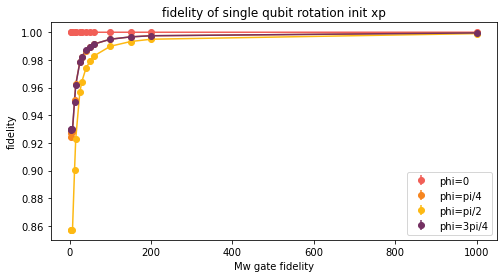

In [459]:

plt.figure(figsize=(8, 4))
plt.plot(contrast_list[:-1], fid_ave[::len(phi1)][:-1], color=c1)
plt.errorbar(contrast_list[:-1],  fid_ave[::len(phi1)][:-1], yerr= fid_err[::len(phi1)][:-1],  fmt='o', color=c1, label='phi=0')
plt.plot(contrast_list[:-1], fid_ave[1::len(phi1)][:-1], color=c2)
plt.errorbar(contrast_list[:-1],  fid_ave[1::len(phi1)][:-1], yerr= fid_err[1::len(phi1)][:-1],  fmt='o', color=c2, label='phi=pi/4')
plt.plot(contrast_list[:-1], fid_ave[2::len(phi1)][:-1], color=c3)
plt.errorbar(contrast_list[:-1],  fid_ave[2::len(phi1)][:-1], yerr= fid_err[2::len(phi1)][:-1],  fmt='o', color=c3, label='phi=pi/2')
plt.plot(contrast_list[:-1], fid_ave[3::len(phi1)][:-1], color=c4)
plt.errorbar(contrast_list[:-1],  fid_ave[3::len(phi1)][:-1], yerr= fid_err[3::len(phi1)][:-1],  fmt='o', color=c4, label='phi=3pi/4')

#Add labels and title
plt.xlabel('Mw gate fidelity')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation init xp')
plt.legend()
plt.savefig('/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/Figures/PaperFigs/Fid_xpinit_mu0002_vs_mw.pdf', format='pdf')   # Save as PDF


# Show the plot
plt.show()

#### Blindness of the gates

In [464]:
hol_err =  np.empty((0, 2), dtype=float)
hol_ave =  np.empty((0, 2), dtype=float)

for i in range(len(contrast_list)):
    print(i)
    rho_ave_phi_array =  np.empty((0, 2, 2), dtype=float)
    eigen_phi_std_array = np.empty((0, 2), dtype=float)
    eig_eta_array = np.empty((0, 2), dtype=float)
    for j in range(len(phi1)):
        nxnynz_array =  np.empty((0, 3), dtype=float)
        for k in range(n_rounds):
            nx, ny, nz = calculate_bloch_components(qt.Qobj(rho_contr_phi_n_array_cl[i][j][k]))
            nxnynz_array =  np.vstack([nxnynz_array, [nx, ny, nz]])
        mean_nxnynz = np.mean(nxnynz_array, axis =0)
        std_nxnynz = np.std(nxnynz_array, axis =0)/np.sqrt(n_rounds)
        std_eigen_eta = eigenvalue_uncertainty(mean_nxnynz, std_nxnynz)
        eigen_eta = [(1/2)*(1 -np.sqrt(np.sum(mean_nxnynz**2))), (1/2)*(1 +np.sqrt(np.sum(mean_nxnynz**2)))]
        # print(eigen_eta, std_eigen_eta)

        eig_eta_array = np.append(eig_eta_array, np.array([eigen_eta]))
        # density state for a phi
        rho_ave_phi = np.mean(rho_contr_phi_n_array_s[i][j], axis = 0)
        rho_ave_phi_array = np.append(rho_ave_phi_array, [rho_ave_phi], axis = 0)
        eigen_phi_std_array = np.append(eigen_phi_std_array, std_eigen_eta)

    rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)
    nxnynz = np.array([calculate_bloch_components(qt.Qobj(rho_ave_tot))])
    nxnynz_std = np.sqrt(np.sum(eigen_phi_std_array**2))/len(eigen_phi_std_array)

    # std of variability of eigenvalues of rho tot
    std_eigen_eta = eigenvalue_uncertainty(nxnynz.ravel(), [nxnynz_std,nxnynz_std,nxnynz_std])
    eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())

    hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])
    rho_tot_sigma_lambdas = (std_eigen_eta, std_eigen_eta)
    rho_tot_lambdas = (eigen_tot[0], eigen_tot[1])
    rho_lambdas = [(eig_eta_array[i], eig_eta_array[i+1]) for i in range(0, len(eig_eta_array), 2)] 
    rho_sigma_lambdas =  [(value, value) for value in eigen_phi_std_array]
    print(rho_tot_lambdas)
    print(rho_tot_sigma_lambdas)
    print(rho_lambdas)
    print(rho_sigma_lambdas)

    hv_std = holevo_bound_uncertainty(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)
    hol_ave = np.append(hol_ave, hv_tot)
    hol_err = np.append(hol_err, hv_std)


0
(0.1478701945293982, 0.8521298054706016)
(0.001452662207252781, 0.001452662207252781)
[(4.090475292928275e-07, 0.9999995909524707), (0.0685253659769986, 0.9314746340230013), (0.142739721306683, 0.857260278693317), (0.06342772792849422, 0.9365722720715057)]
[(1.7791463081160145e-08, 1.7791463081160145e-08), (0.008317361938023916, 0.008317361938023916), (0.00048749257759875427, 0.00048749257759875427), (0.00810175293592282, 0.00810175293592282)]
1
(0.15866749714397904, 0.8413325028560207)
(0.0014607589571909582, 0.0014607589571909582)
[(4.4850681840680195e-07, 0.9999995514931816), (0.07278095162826281, 0.9272190483717372), (0.14289061137094566, 0.8571093886290544), (0.06226763385729772, 0.9377323661427023)]
[(1.9496149445164527e-08, 1.9496149445164527e-08), (0.008470919118634665, 0.008470919118634665), (0.00018296749453002557, 0.00018296749453002557), (0.008048249683377522, 0.008048249683377522)]
2
(0.14076113155869288, 0.8592388684413069)
(0.00144201922187738, 0.00144201922187738)
[(3

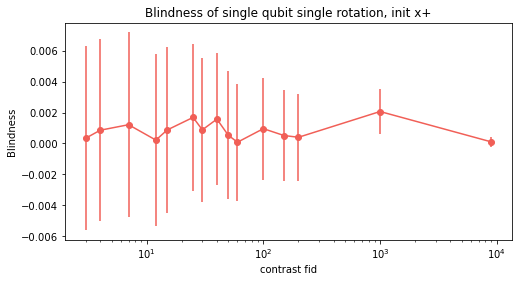

In [472]:
plt.figure(figsize=(8, 4))
plt.plot(contrast_list, hol_ave, color=c1)
plt.errorbar(contrast_list,  hol_ave, yerr= hol_err,  fmt='o', color=c1)

#Add labels and title
plt.xlabel('contrast fid')
plt.xscale('log')
plt.ylabel('Blindness')
plt.title('Blindness of single qubit single rotation, init x+')
plt.savefig('/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/Figures/PaperFigs/Blind_xpinit_mu0002_vs_contrast.pdf', format='pdf')   # Save as PDF


# Show the plot
plt.show()

In [468]:
hol_ave

array([3.31720076e-04, 8.52302579e-04, 1.21005998e-03, 2.13120210e-04,
       8.69296442e-04, 1.68367759e-03, 8.76288469e-04, 1.57344300e-03,
       5.31588002e-04, 7.48863564e-05, 9.53873178e-04, 5.10102056e-04,
       3.95363841e-04, 2.06514736e-03, 9.39933329e-05])

In [469]:
hol_err

array([0.00595546, 0.00590744, 0.00598153, 0.00557996, 0.00540876,
       0.00478729, 0.00468961, 0.00425401, 0.00415893, 0.00380296,
       0.00330066, 0.00296327, 0.00282635, 0.00147687, 0.00030999])

#### Save density matrices 

In [ ]:
import datetime

# Example complex matrices

# Convert the complex matrices to string representation
data = {
    'rho_ave_s': [str(rho_ave_s_phi_mw.tolist())],
    'rho_std_s': [str(rho_std_s_phi_mw.tolist())],  # Replace with actual std data
    'rho_ave_cl': [str(rho_ave_cl_phi_mw.tolist())],  # Replace with actual cl data
    'rho_std_cl': [str(rho_std_cl_phi_mw.tolist())]  # Replace with actual cl std data
}

df = pd.DataFrame(data)

# File path for the output CSV
# file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/SingleGates_xpinit_rhos_phis_{n_rounds}pts_mu{mu}_mw_list_perfcontr_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/dummy.csv'

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)


#### Retrieve the densities

In [ ]:
import ast

# File path for the input CSV
file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/dummy.csv'
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Convert the string representations back into arrays
def string_to_array(string):
    # Use ast.literal_eval to safely evaluate the string to a list
    list_repr = ast.literal_eval(string)
    # Convert the list back to a NumPy array
    return np.array(list_repr, dtype=complex)

# Apply the conversion to the relevant columns
df['rho_ave_s'] = df['rho_ave_s'].apply(string_to_array)
df['rho_std_s'] = df['rho_std_s'].apply(string_to_array)
df['rho_ave_cl'] = df['rho_ave_cl'].apply(string_to_array)
df['rho_std_cl'] = df['rho_std_cl'].apply(string_to_array)

# Now you can access the arrays
rho_ave_s = df['rho_ave_s'][0]
rho_std_s = df['rho_std_s'][0]
rho_ave_cl = df['rho_ave_cl'][0]
rho_std_cl = df['rho_std_cl'][0]



In [ ]:
# Client's data
 
rho_ave_cl_0_mw = np.array(rho_ave_cl[0:len(mw_list)])
rho_ave_cl_pi4_mw = np.array(rho_ave_cl[len(mw_list):2*len(mw_list)])
rho_ave_cl_pi2_mw = np.array(rho_ave_cl[2*len(mw_list):3*len(mw_list)])
rho_ave_cl_3pi4_mw = np.array(rho_ave_cl[3*len(mw_list):])
rho_ave_cl_phis = [rho_ave_cl_0_mw, rho_ave_cl_pi4_mw, rho_ave_cl_pi2_mw, rho_ave_cl_3pi4_mw]

rho_std_cl_0_mw = np.array(rho_std_cl[0:len(mw_list)])
rho_std_cl_pi4_mw = np.array(rho_std_cl[len(mw_list):2*len(mw_list)])
rho_std_cl_pi2_mw = np.array(rho_std_cl[2*len(mw_list):3*len(mw_list)])
rho_std_cl_3pi4_mw = np.array(rho_std_cl[3*len(mw_list):])
rho_std_cl_phis = [rho_std_cl_0_mw, rho_std_cl_pi4_mw, rho_std_cl_pi2_mw, rho_std_cl_3pi4_mw]

# Server's data
 
rho_ave_s_0_mw = np.array(rho_ave_s[0:len(mw_list)])
rho_ave_s_pi4_mw = np.array(rho_ave_s[len(mw_list):2*len(mw_list)])
rho_ave_s_pi2_mw = np.array(rho_ave_s[2*len(mw_list):3*len(mw_list)])
rho_ave_s_3pi4_mw = np.array(rho_ave_s[3*len(mw_list):])
rho_ave_s_phis = [rho_ave_s_0_mw, rho_ave_s_pi4_mw, rho_ave_s_pi2_mw, rho_ave_s_3pi4_mw]

rho_std_s_0_mw = np.array(rho_std_cl[0:len(mw_list)])
rho_std_s_pi4_mw = np.array(rho_std_cl[len(mw_list):2*len(mw_list)])
rho_std_s_pi2_mw = np.array(rho_std_cl[2*len(mw_list):3*len(mw_list)])
rho_std_s_3pi4_mw = np.array(rho_std_cl[3*len(mw_list):])
rho_std_s_phis = [rho_std_s_0_mw, rho_std_s_pi4_mw, rho_std_s_pi2_mw, rho_std_s_3pi4_mw]

In [ ]:
rho_ave_cl_phis

In [ ]:
rho_std_cl_phis

In [ ]:

plt.figure(figsize=(8, 4))
plt.plot(mw_list, fid_phi_mw[0:len(mw_list)], color=c1)
plt.errorbar(mw_list,  fid_phi_mw[0:len(mw_list)], yerr= fid_err_phi_mw[0:len(mw_list)]/np.sqrt(n_rounds),  fmt='o', color=c1, label='phi=0')
plt.plot(mw_list, fid_phi_mw[len(mw_list):2*len(mw_list)], color=c2)
plt.errorbar(mw_list,  fid_phi_mw[len(mw_list):2*len(mw_list)], yerr= fid_err_phi_mw[len(mw_list):2*len(mw_list)]/np.sqrt(n_rounds),  fmt='o', color=c2,  label='phi=pi/4')
plt.plot(mw_list, fid_phi_mw[2*len(mw_list):3*len(mw_list)], color=c3)
plt.errorbar(mw_list,  fid_phi_mw[2*len(mw_list):3*len(mw_list)], yerr= fid_err_phi_mw[2*len(mw_list):3*len(mw_list)]/np.sqrt(n_rounds),  fmt='o', color=c3, label='phi=pi/2')
plt.plot(mw_list, fid_phi_mw[3*len(mw_list):], color=c4)
plt.errorbar(mw_list,  fid_phi_mw[3*len(mw_list):], yerr= fid_err_phi_mw[3*len(mw_list):]/np.sqrt(n_rounds),  fmt='o', color=c4, label='phi=3pi/4')

#Add labels and title
plt.xlabel('Mw gate fidelity')
plt.ylabel('fidelity')
plt.title('fidelity of single qubit rotation init xp')
plt.legend()

# Show the plot
plt.show()

In [ ]:
holevo_mw

In [ ]:
holevo_err_mw

In [ ]:
rho_phi_array = rho_ave_mw[0]
# Calculate the average density matrix
rho_all = np.mean(rho_phi_array, axis=0)

# Calculate the mean entropy of the individual density matrices
mn = np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_phi_array])

# Calculate the Holevo bound
holevo = qt.entropy_vn(qt.Qobj(rho_all)) - mn


In [ ]:
mn

In [ ]:
holevo

In [ ]:
mx = 0.5*qt.identity(2)
qt.entropy_vn(mx)

In [ ]:
qt.entropy_vn(qt.Qobj(rho_all))

In [ ]:
np.log(1.02)

In [ ]:
holevo_mw

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(mw_list, holevo_mw, color=c1)
plt.errorbar(mw_list,  holevo_mw, yerr= np.abs(holevo_err_mw)/np.sqrt(n_rounds),  fmt='o', color=c1)

#Add labels and title
plt.xlabel('MW fid')
plt.ylabel('Blindness')
plt.title('Blindness of single qubit single rotation, init xp')

# Show the plot
plt.show()

## Extra

In [ ]:
## Perfect single qubit gates with all init states and all final states

imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect' #'real'
               }

el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())
el_initial_xm  = qt.ket2dm((qt.basis(2,0)- qt.basis(2,1)).unit())
el_initial_yp  = qt.ket2dm((qt.basis(2,0)+ 1j*qt.basis(2,1)).unit())
el_initial_ym  = qt.ket2dm((qt.basis(2,0)- 1j*qt.basis(2,1)).unit())
el_initial_zp  = qt.ket2dm((qt.basis(2,0)).unit())
el_initial_zm  = qt.ket2dm((qt.basis(2,1)).unit())

mu = 0.01
# sim.single_node_electron_photon_entanglement(el_initial, imperfections, mu)

cluster_state_length = 1
phi1 = 0
phi2 = 0
phi3 = 0

n_rounds = 40
n_col = 6

xp_array = np.empty((0, n_col), dtype=float)
xm_array = np.empty((0, n_col), dtype=float)
yp_array = np.empty((0, n_col), dtype=float)
ym_array = np.empty((0, n_col), dtype=float)
zp_array = np.empty((0, n_col), dtype=float)
zm_array = np.empty((0, n_col), dtype=float)

rho_init_xp_array = np.empty((2, 2), dtype=float)
rho_init_xm_array = np.empty((2, 2), dtype=float)
rho_init_yp_array = np.empty((2, 2), dtype=float)
rho_init_ym_array = np.empty((2, 2), dtype=float)
rho_init_zp_array = np.empty((2, 2), dtype=float)
rho_init_zm_array = np.empty((2, 2), dtype=float)

for i in range(n_rounds): 
    rho_init_xp, Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
    rho_init_xm, Xxm_c, Yxm_c, Zxm_c, Xxm_s, Yxm_s, Zxm_s = sim.single_node_electron_exp(el_initial_xm, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
    rho_init_yp, Xyp_c, Yyp_c, Zyp_c, Xyp_s, Yyp_s, Zyp_s = sim.single_node_electron_exp(el_initial_yp, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
    rho_init_ym, Xym_c, Yym_c, Zym_c, Xym_s, Yym_s, Zym_s = sim.single_node_electron_exp(el_initial_ym, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
    rho_init_zp, Xzp_c, Yzp_c, Zzp_c, Xzp_s, Yzp_s, Zzp_s = sim.single_node_electron_exp(el_initial_zp, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
    rho_init_zm, Xzm_c, Yzm_c, Zzm_c, Xzm_s, Yzm_s, Zzm_s = sim.single_node_electron_exp(el_initial_zm, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
    
    rho_init_xp_array = np.append(rho_init_xp_array, rho_init_xp[0], axis = 0)
    rho_init_xm_array = np.append(rho_init_xm_array, rho_init_xm[0], axis = 0)
    rho_init_yp_array = np.append(rho_init_yp_array, rho_init_yp[0], axis = 0)
    rho_init_ym_array = np.append(rho_init_ym_array, rho_init_ym[0], axis = 0)
    rho_init_zp_array = np.append(rho_init_zp_array, rho_init_zp[0], axis = 0)
    rho_init_zm_array = np.append(rho_init_zm_array, rho_init_zm[0], axis = 0)

    xp_array = np.append(xp_array, [[Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s]], axis = 0)
    xm_array = np.append(xm_array, [[Xxm_c, Yxm_c, Zxm_c, Xxm_s, Yxm_s, Zxm_s]], axis = 0)
    yp_array = np.append(yp_array, [[Xyp_c, Yyp_c, Zyp_c, Xyp_s, Yyp_s, Zyp_s]], axis = 0)
    ym_array = np.append(ym_array, [[Xym_c, Yym_c, Zym_c, Xym_s, Yym_s, Zym_s]], axis = 0)
    zp_array = np.append(zp_array, [[Xzp_c, Yzp_c, Zzp_c, Xzp_s, Yzp_s, Zzp_s]], axis = 0)
    zm_array = np.append(zm_array, [[Xzm_c, Yzm_c, Zzm_c, Xzm_s, Yzm_s, Zzm_s]], axis = 0)


# Average the data and save as a dict

data = {
    '+ X mean': [np.mean(xp_array[:, i]) for i in range(6)],
    '+ X std': [np.std(xp_array[:, i], ddof=1) for i in range(6)],
    '- X mean': [np.mean(xm_array[:, i]) for i in range(6)],
    '- X std': [np.std(xm_array[:, i], ddof=1) for i in range(6)],
    '+ Y mean': [np.mean(yp_array[:, i]) for i in range(6)],
    '+ Y std': [np.std(yp_array[:, i], ddof=1) for i in range(6)],
    '- Y mean': [np.mean(ym_array[:, i]) for i in range(6)],
    '- Y std': [np.std(ym_array[:, i], ddof=1) for i in range(6)],
    '+ Z mean': [np.mean(zp_array[:, i]) for i in range(6)],
    '+ Z std': [np.std(zp_array[:, i], ddof=1) for i in range(6)],
    '- Z mean': [np.mean(zm_array[:, i]) for i in range(6)],
    '- Z std': [np.std(zm_array[:, i], ddof=1) for i in range(6)]
}

# Creating a DataFrame
df = pd.DataFrame(data)
df.columns = ['+ X mean', '+ X std', '- X mean', '- X std', '+ Y mean', '+ Y std', '- Y mean', '- Y std', '+ Z mean', '+ Z std', '- Z mean', '- Z std']

# Display the DataFrame
print("Table displayed in Python environment:")
print(df)

# # File path for the output CSV
# file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/TableSingleGates_phi1{phi1}_{n_rounds}pts_mu{mu}_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

# # Write the DataFrame to a CSV file
# df.to_csv(file_path, index=False)


In [ ]:
imperfections = {'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect' #'real'
               }

el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())
el_initial_xm  = qt.ket2dm((qt.basis(2,0)- qt.basis(2,1)).unit())
el_initial_yp  = qt.ket2dm((qt.basis(2,0)+ 1j*qt.basis(2,1)).unit())
el_initial_ym  = qt.ket2dm((qt.basis(2,0)- 1j*qt.basis(2,1)).unit())
el_initial_zp  = qt.ket2dm((qt.basis(2,0)).unit())
el_initial_zm  = qt.ket2dm((qt.basis(2,1)).unit())

cluster_state_length = 1
phi1 = 3*np.pi/2
phi2 = 0
phi3 = 0

n_rounds = 40
n_col = 6
averphi3pi2 = []
mu_list = np.linspace(0.001, 0.7, num=2)
for mu in mu_list:
    print(mu)
    xp_array = np.empty((0, n_col), dtype=float)
    xm_array = np.empty((0, n_col), dtype=float)
    yp_array = np.empty((0, n_col), dtype=float)
    ym_array = np.empty((0, n_col), dtype=float)
    zp_array = np.empty((0, n_col), dtype=float)
    zm_array = np.empty((0, n_col), dtype=float)

    for i in range(n_rounds): 
        Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
        Xxm_c, Yxm_c, Zxm_c, Xxm_s, Yxm_s, Zxm_s = sim.single_node_electron_exp(el_initial_xm, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
        Xyp_c, Yyp_c, Zyp_c, Xyp_s, Yyp_s, Zyp_s = sim.single_node_electron_exp(el_initial_yp, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
        Xym_c, Yym_c, Zym_c, Xym_s, Yym_s, Zym_s = sim.single_node_electron_exp(el_initial_ym, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
        Xzp_c, Yzp_c, Zzp_c, Xzp_s, Yzp_s, Zzp_s = sim.single_node_electron_exp(el_initial_zp, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
        Xzm_c, Yzm_c, Zzm_c, Xzm_s, Yzm_s, Zzm_s = sim.single_node_electron_exp(el_initial_zm, imperfections, cluster_state_length, phi1, phi1, phi3, mu)
        xp_array = np.append(xp_array, [[Xxp_c, Yxp_c, Zxp_c, Xxp_s, Yxp_s, Zxp_s]], axis = 0)
        xm_array = np.append(xm_array, [[Xxm_c, Yxm_c, Zxm_c, Xxm_s, Yxm_s, Zxm_s]], axis = 0)
        yp_array = np.append(yp_array, [[Xyp_c, Yyp_c, Zyp_c, Xyp_s, Yyp_s, Zyp_s]], axis = 0)
        ym_array = np.append(ym_array, [[Xym_c, Yym_c, Zym_c, Xym_s, Yym_s, Zym_s]], axis = 0)
        zp_array = np.append(zp_array, [[Xzp_c, Yzp_c, Zzp_c, Xzp_s, Yzp_s, Zzp_s]], axis = 0)
        zm_array = np.append(zm_array, [[Xzm_c, Yzm_c, Zzm_c, Xzm_s, Yzm_s, Zzm_s]], axis = 0)


    # Average the data and save as a dict
        
    data = {
        '+ X init': [f"{np.mean(xp_array[:, i]):.2f} ± {np.std(xp_array[:, i], ddof=1):.2f}" for i in range(6)],
        '- X init': [f"{np.mean(xm_array[:, i]):.2f} ± {np.std(xm_array[:, i], ddof=1):.2f}" for i in range(6)],
        '+ Y init': [f"{np.mean(yp_array[:, i]):.2f} ± {np.std(yp_array[:, i], ddof=1):.2f}" for i in range(6)],
        '- Y init': [f"{np.mean(ym_array[:, i]):.2f} ± {np.std(ym_array[:, i], ddof=1):.2f}" for i in range(6)],
        '+ Z init': [f"{np.mean(zp_array[:, i]):.2f} ± {np.std(zp_array[:, i], ddof=1):.2f}" for i in range(6)],
        '- Z init': [f"{np.mean(zm_array[:, i]):.2f} ± {np.std(zm_array[:, i], ddof=1):.2f}" for i in range(6)]
    }

    # i = 0
    # j = 1
    # k = 2

    # averphi0.append({np.mean([
    #     np.abs(np.mean(xp_array[:, i])),
    #     np.abs(np.mean(xm_array[:, i])),
    #     np.abs(np.mean(yp_array[:, j])),
    #     np.abs(np.mean(ym_array[:, j])),
    #     np.abs(np.mean(zp_array[:, k])),
    #     np.abs(np.mean(zm_array[:, k]))
    # ]), np.sqrt(np.sum([
    #     np.std(xp_array[:, i], ddof=1)**2,
    #     np.std(xm_array[:, i], ddof=1)**2,
    #     np.std(yp_array[:, j], ddof=1)**2,
    #     np.std(ym_array[:, j], ddof=1)**2,
    #     np.std(zp_array[:, k], ddof=1)**2,
    #     np.std(zm_array[:, k], ddof=1)**2
    # ])), })

    i = 1
    j = 0
    k = 2

    averphi3pi2.append({np.mean([
        np.abs(np.mean(xp_array[:, i])),
        np.abs(np.mean(xm_array[:, i])),
        np.abs(np.mean(yp_array[:, j])),
        np.abs(np.mean(ym_array[:, j])),
        np.abs(np.mean(zp_array[:, k])),
        np.abs(np.mean(zm_array[:, k]))
    ]), np.sqrt(np.sum([
        np.std(xp_array[:, i], ddof=1)**2,
        np.std(xm_array[:, i], ddof=1)**2,
        np.std(yp_array[:, j], ddof=1)**2,
        np.std(ym_array[:, j], ddof=1)**2,
        np.std(zp_array[:, k], ddof=1)**2,
        np.std(zm_array[:, k], ddof=1)**2
    ])), })

    # Creating a DataFrame
    df = pd.DataFrame.from_dict(data, orient = 'index')
    df.columns = ['X meas c', 'Y meas c', 'Z meas c', 'X meas s', 'Y meas s', 'Z meas s']

    # Display the DataFrame
    print("Table displayed in Python environment:")
    print(df)

    # File path for the output
    file_path = f'/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/TableSingleGates_phi1_{phi1:.1f}_{n_rounds}pts_mu{mu:.2f}_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.txt'

    # Write the DataFrame to a text file
    with open(file_path, 'w') as file:
        file.write(df.to_string(index=True))

In [ ]:
#separate the results of the experiment 
 
rho_ave_cl_0_mu = rho_ave_cl_phi_mu[0:len(mu_list)]
rho_ave_cl_pi4_mu = rho_ave_cl_phi_mu[len(mu_list):2*len(mu_list)]
rho_ave_cl_pi2_mu = rho_ave_cl_phi_mu[2*len(mu_list):3*len(mu_list)]
rho_ave_cl_3pi4_mu = rho_ave_cl_phi_mu[3*len(mu_list):]
rho_ave_cl_phis = [rho_ave_cl_0_mu, rho_ave_cl_pi4_mu, rho_ave_cl_pi2_mu, rho_ave_cl_3pi4_mu]

rho_std_cl_0_mu = rho_std_cl_phi_mu[0:len(mu_list)]
rho_std_cl_pi4_mu = rho_std_cl_phi_mu[len(mu_list):2*len(mu_list)]
rho_std_cl_pi2_mu = rho_std_cl_phi_mu[2*len(mu_list):3*len(mu_list)]
rho_std_cl_3pi4_mu = rho_std_cl_phi_mu[3*len(mu_list):]
rho_std_cl_phis = [rho_std_cl_0_mu, rho_std_cl_pi4_mu, rho_std_cl_pi2_mu, rho_std_cl_3pi4_mu]


In [ ]:
# save by hand

ave = [[[0.0, 1.0],[0.002016597794967225, 0.9759500000000001],[0.004044622894532245, 0.9533833333333334],[0.0050207901104640275, 0.9315625000000001],
 [0.007013448619506785, 0.910275],
 [0.008086709577749897, 0.8900666666666667],
 [0.01002880466840008, 0.8702916666666667],
 [0.011024651863798193, 0.8517125],
 [0.011038713925462755, 0.8336208333333334],
 [0.011711926859796854, 0.8153]], [[0.0, 1.0],
 [2.24873312656119e-16, 0.976],
 [0.0, 0.9533333333333335],
 [0.0, 0.9313333333333333],
 [0.0, 0.9106666666666667],
 [0.0, 0.89],
 [0.0, 0.8706666666666667],
 [0.0, 0.852],
 [0.0, 0.8333333333333334],
 [0.0, 0.816]], [[0.0, 1.0],
 [0.002016597794967225, 0.9759833333333333],
 [0.004008964314108433, 0.9531833333333334],
 [0.00500960615679056, 0.9315833333333333],
 [0.0070358058602099155, 0.91045],
 [0.00799487015016184, 0.8902000000000001],
 [0.010057526840821571, 0.8705833333333334],
 [0.010950529784631555, 0.8517583333333333],
 [0.011126199157497942, 0.8336666666666667],
 [0.011926699201629682, 0.81635]], [[0.0, 1.0],
 [2.24873312656119e-16, 0.976],
 [0.0, 0.9533333333333335],
 [0.0, 0.9313333333333333],
 [0.0, 0.9106666666666667],
 [0.0, 0.89],
 [0.0, 0.8706666666666667],
 [0.0, 0.852],
 [0.0, 0.8333333333333334],
 [0.0, 0.816]]]

In [ ]:
average_data = (np.array(ave)[0][:,1] + np.array(ave)[1][:,1] + np.array(ave)[2][:,1] + np.array(ave)[3][:,1])/4

In [ ]:
average_data

In [ ]:
plt.plot(mu_list, average_data, label = '')
plt.xlabel('mu')
plt.ylabel('Average fidelity')
plt.yscale('linear')
plt.xscale('linear')
plt.title('Client side') 

In [ ]:
average = []

In [ ]:
np.append(average, averphi0)

In [ ]:
## Calculate averages
file_path = '/Users/azizasuleymanzade/Dropbox (Personal)/AzizaOnly/LukinLab/BlindComputing/SimulationCode_Aziza/SimulationCode/OutputFiles/BlindComputing/TableSingleGates_phi1_0.00_10pts_mu0.5_2024-05-01_23-47-59.txt'

with open(file_path, 'r') as file:
    lines = file.readlines()

for line in lines:
    print(line.strip())

parts = line.split('±')  # Split the string into parts

# Extract numbers from parts
mean = float(parts[0].strip())  # Convert the first part to float
std_dev = float(parts[1].strip())  # Convert the second part to float

print("Mean:", mean)
print("Standard Deviation:", std_dev)

In [ ]:
xp_array[:, 1]

In [ ]:
xp_array[:, 3]

In [ ]:
xp_array[:, 0]